# **MIMIC IV - Preprocessing**
### **Setup**
* Importing necessary libraries.

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import wfdb
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import unittest
import time
from ecg_dataset import ECGDataset
import os
import wget
import gzip
import csv
from fuzzywuzzy import fuzz, process
import render_signals_as_images as rsi
import multiprocessing 
from functools import partial
from concurrent.futures import ThreadPoolExecutor
import sys
from matplotlib import pylab
import matplotlib.pyplot as plt 
import seaborn as sns
import shutil
from matplotlib.ticker import FuncFormatter
params = {'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'axes.titlesize' : 22,
        'axes.labelsize' : 20,
        'legend.fontsize': 18,
        'legend.title_fontsize': 22,
        'figure.titlesize': 24}
pylab.rcParams.update(params) 
plt.rcParams['figure.figsize'] = [30, 15]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Function to download and extract a gz file
def download_and_extract_gz(file_url, folder_path):
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Get the file name from the URL
    file_name = file_url.split('/')[-1]

    # Download the file using wget
    gz_file_path = os.path.join(folder_path, file_name)
    wget.download(file_url, gz_file_path)

    # Extract the contents of the gz file and save as CSV
    csv_file_path = os.path.join(folder_path, file_name.replace('.gz', ''))
    with gzip.open(gz_file_path, 'rb') as gz_file:
        with open(csv_file_path, 'wb') as csv_file:
            csv_file.write(gz_file.read())

    # Return the CSV file path
    return csv_file_path

## ***Part I: Preprocessing the free text diagnosis descriptions.***
### **Step 1: Reading and processing all medical reports.**  
* 1.1: Standardizing all reports to lower case.
* 1.2: Deleting usless prefixes and suffixes. 
* 1.3: Creating unique reports set, free of duplicates. 
* 1.4: Saving it into a csv file for manual string matching. 

In [3]:
unique_report_types = set()
reports_file_path = 'all_data\machine_measurements.csv' 
with open(reports_file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    for row in csv_reader:
        subject_id = row['subject_id']
        study_id = row['study_id']
        report_columns = [f'report_{i}' for i in range(17)] 
        reports = [row[column].lower() for column in report_columns if row[column]]  # Extract non-empty reports
        unique_report_types.update(reports)

    print("Number of Unique Report Types:", len(unique_report_types))

    new_unique_report_types = set()
    for report in unique_report_types:
        if report.endswith('.'):
            report = report[:-1].strip()
            new_unique_report_types.add(report)
        else:
            new_unique_report_types.add(report)
    unique_report_types = new_unique_report_types.copy()
    new_unique_report_types = set()
    print("Number of Unique Report Types After Removing '.' :", len(unique_report_types)) #3718

    for report in unique_report_types:
        if report.startswith('- '):
            report = report[1:].lstrip()
            new_unique_report_types.add(report)
        elif report.startswith('summary:'):
            report = report[8:].lstrip()
            new_unique_report_types.add(report)
        else: new_unique_report_types.add(report)
    unique_report_types = new_unique_report_types.copy()
    new_unique_report_types = set()
    print("Number of Unique Report Types After Removing '=- ' and 'summary:' at beggining :", len(unique_report_types))

    df = pd.DataFrame(unique_report_types)
    df.to_csv('unique_report_types.csv', index=False, header=False)

Number of Unique Report Types: 3723
Number of Unique Report Types After Removing '.' : 3126
Number of Unique Report Types After Removing '=- ' and 'summary:' at beggining : 3088


* Unfortunately, the ECG reports were poorly typed, often containing shortcut and abbreviations.
* Hence, we've decided to manually match the recognized categories (from catergories.csv) to a 'tags' file (named tags.csv)
* Every free-text diagnosis was associated with at least one predefined category. If a free-text diagnosis matched several categories, they were separated by commas.

In [4]:
our_classification_df = pd.read_csv('tags.csv')
diagnosis_map = {}      # manually fitted diagnosis map.

for index, row in our_classification_df.iterrows():
    manual_classification = row['Our Classification']
    free_text_diagnosis = row['Unique Report']
    
    #TODO: delete the following 'if' for the final submission
    if pd.isna(manual_classification) or manual_classification == '?':
        continue
    
    key_split = manual_classification.split(',')  # csv file - comma seperated file
    key_split = [k.strip() for k in key_split]  # removing whitespace both at the begining and the end of a string.
    
    # Check if there is more than one category that was matches the free-text diagnosis
    if len(key_split) > 1:
        for k in key_split:
            if k not in ('?', '', 'Ignore') and not k.startswith('?'):
                diagnosis_map.setdefault(k, []).append(free_text_diagnosis)
    
    # else, there is single category that matches the free-text diagnosis.
    else:
        manual_classification = manual_classification.strip()
        if manual_classification not in ('?', '', 'Ignore') and not manual_classification.startswith('?'):
            diagnosis_map.setdefault(manual_classification, []).append(free_text_diagnosis)


#### Step 2: Categories binary classification
* 2.1: Creating a binary classification matrix by using the manual mapping we've create in Step 1. 
* An ECG binary matrix is used to indicate the presence of diagnosis keys for each ECG record. In this matrix, each row represents an ECG record, and each column corresponds to a diagnosis key. A value of '1' in a cell indicates that the corresponding diagnosis key is associated with the ECG record, while a '0' indicates the absence of that diagnosis key.

In [5]:

# Remove the excess from the free-text diagnosis. 
# removes: '.', '- ', 'summary:', '' (empty string). 
def clean_report(report):
    # Check for NaN values and return an empty string if encountered
    if pd.isna(report):
        return ''
    # Convert the report to lowercase for consistency
    report = report.lower()
    # Remove a trailing period and leading hyphen or 'summary:' if they exist
    if report.endswith('.'):
        report = report[:-1].strip()
    if report.startswith('- '):
        report = report[1:].lstrip()
    elif report.startswith('summary:'):
        report = report[8:].lstrip()
    # Return the cleaned report
    return report

# Classifies the reports using the mapping we've established previously.
def classify_report(row):
    # Clean the reports in the specified columns
    cleaned_reports = row[report_columns].apply(clean_report)

    # Remove empty reports
    cleaned_reports = cleaned_reports[cleaned_reports != '']

    # Iterate through the diagnosis keys
    for key in diagnosis_map:
        # Check if any report in cleaned_reports matches the current diagnosis key
        if any(report in diagnosis_map[key] for report in cleaned_reports):
            # Set a flag in the 'image_to_reports_df' DataFrame to indicate the match
            image_to_reports_df.loc[row.name, key] = 1


# default names given to columns in the MIMIC-IV ECG database for the free-text diagnosis
reports_col_name = ['report_0', 'report_1', 'report_2', 'report_3', 'report_4', 'report_5', 'report_6', 'report_7', 'report_8', 'report_9', 'report_10', 'report_11', 'report_12', 'report_13', 'report_14', 'report_15', 'report_16','report_17']

file_to_check = "image_to_diagnosis_all.csv"
file_path = os.path.join(os.getcwd(), file_to_check)
if not os.path.exists(file_path):
    # Create an empty DataFrame with specified columns
    image_to_reports_df = pd.DataFrame(columns=['subject_id', 'study_id', 'image_id'])

    # Create a DataFrame with columns based on diagnosis keys
    diagnois_columns = pd.DataFrame(columns=diagnosis_map.keys())

    # Concatenate the two DataFrames horizontally (along columns) to combine them
    image_to_reports_df = pd.concat([image_to_reports_df, diagnois_columns], axis=1)
    
    # Define the path to the reports file
    reports_file_path = 'all_data/machine_measurements.csv'  # Using forward slash for the file path

    # Create a list of report column names using a list comprehension
    report_columns = [f'report_{i}' for i in range(17)]

    # Read the CSV file into a DataFrame
    reports_df = pd.read_csv(reports_file_path)

    # Copy 'subject_id' and 'study_id' columns from reports_df to image_to_reports_df
    image_to_reports_df['subject_id'] = reports_df['subject_id']
    image_to_reports_df['study_id'] = reports_df['study_id']

    # Create 'image_id' by combining 'subject_id' and 'study_id' as strings
    image_to_reports_df['image_id'] = reports_df['subject_id'].astype(str) + '_' + reports_df['study_id'].astype(str)

    # Fill any NaN values in image_to_reports_df with 0
    image_to_reports_df = image_to_reports_df.fillna(0)

    # Create a list of DataFrames to concatenate
    dataframes_to_concat = [image_to_reports_df, reports_df[report_columns]]

    # Concatenate the DataFrames horizontally (along columns) to combine them
    image_to_reports_df = pd.concat(dataframes_to_concat, axis=1)

    # Apply the 'classify_report' function to each row of the DataFrame
    image_to_reports_df.apply(classify_report, axis=1)

    # Delete the unnecessary report columns from the DataFrame
    image_to_reports_df = image_to_reports_df.drop(columns=report_columns)

    # Save the combined DataFrame to a CSV file
    image_to_reports_df.to_csv('image_to_diagnosis_all.csv', index=False)

else:
    image_to_reports_df = pd.read_csv('image_to_diagnosis_all.csv')

C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\146119398.py:57: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  reports_df = pd.read_csv(reports_file_path)



* 2.2: Handle reports that have been split into two reports.
* Further explaination: for reason unknown, some of the free-text reports which contained the word 'with' were split into two. For example:
Atrial Flutter with rapid ventricular respone' was split into two different reports:
    1. Atrial Flutter 
    2. with rapid ventricular respone

* Hence, we've decided to append the seprated reports in order to gain the full diagnosis.


In [6]:
reports_to_handle = {}      # will contain the problematic reports
csv_df = pd.read_csv('all_data\machine_measurements.csv')
for _,row in csv_df.iterrows():
    for col in reports_col_name:
        free_text_diagnosis = row[col]
        if pd.notna(free_text_diagnosis):
            free_text_diagnosis = clean_report(free_text_diagnosis)
            if free_text_diagnosis == "with rapid ventricular response" or free_text_diagnosis == 'with slow ventricular response':
                study_id = row['study_id']
                subject_id = row['subject_id']
                image_id = str(subject_id) + '_' + str(study_id)
                report_col_index = reports_col_name.index(col)
                report_col_index -= 1
                col_beore = reports_col_name[report_col_index]  
                report_before = row[col_beore]      # takes one report prior the report which starts with the word 'with'
                reports_to_handle[image_id] = {"report": free_text_diagnosis, "report_before": report_before}
                break

C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\219289376.py:2: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_df = pd.read_csv('all_data\machine_measurements.csv')


In [7]:
#print all uniqe before_report
uniqe_before_reports = set()
for report in reports_to_handle:
    report_before = reports_to_handle[report]["report_before"]
    report_before = clean_report(report_before)
    reports_to_handle[report]["report_before"] = report_before
    uniqe_before_reports.add(report_before)
print(uniqe_before_reports)

{'atrial fibrillation', 'probable atrial fibrillation', 'atrial flutter', 'possible idioventricular rhythm', 'possible atrial flutter'}


In [8]:
reports_to_handle_map = {
    'atrial fibrillation' : 'Atrial Fibrillation',
    'probable atrial fibrillation' : 'Atrial Fibrillation',
    'atrial flutter' : 'Atrial Flutter',
    'possible atrial flutter': 'Atrial Flutter',
    'possible idioventricular rhythm' : 'Idioventricular Rhythm'
}

for image_id in reports_to_handle:
    diagnosis = []
    report = reports_to_handle[image_id]["report"]
    report_before = reports_to_handle[image_id]["report_before"]
    diagnosis_before = reports_to_handle_map[report_before]
    row = image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id]
    diagnosis_columns = row.columns[row.iloc[0] == 1]           # takes all the column with '1' in them.
    diagnosis.extend(diagnosis_columns)
    for diagnos in diagnosis:
        if diagnos == diagnosis_before:
            image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, diagnos] = 0       # resets, bcause the cateories arediffrent
            if report == "with rapid ventricular response":
                if diagnosis_before == 'Atrial Fibrillation': 
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Atrial Fibrillation with a Rapid Ventricular Rate'] = 1
                elif diagnosis_before == 'Atrial Flutter':
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Atrial Flutter with a Rapid Ventricular Rate'] = 1
                elif diagnosis_before == 'Idioventricular Rhythm':
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Accelerated Idioventricular Rhythm'] = 1
            elif report == 'with slow ventricular response':
                if diagnosis_before == 'Atrial Fibrillation': 
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Atrial Fibrillation with a Slow Ventricular Rate'] = 1
                elif diagnosis_before == 'Atrial Flutter':
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Atrial Flutter with a Slow Ventricular Rate'] = 1
                elif diagnosis_before == 'Idioventricular Rhythm':
                    image_to_reports_df.loc[image_to_reports_df['image_id'] == image_id, 'Idioventricular Rhythm with a Slow Ventricular Rate'] = 1

image_to_reports_df.to_csv('image_to_diagnosis_all.csv', index=False)

* 2.3: Count the number of ECG images by pre-defined categories

In [9]:
diagnosis_columns = image_to_reports_df.columns[3:]
diagnosis_counts = {key: 0 for key in diagnosis_columns}
for manual_classification in diagnosis_counts:
    diagnosis_counts[manual_classification] = image_to_reports_df[manual_classification].sum()
# diagnosis_counts = {key: diagnosis_counts[key] for key in diagnosis_counts if not key.startswith('?')}
count_df = pd.DataFrame({'Diagnosis': list(diagnosis_counts.keys()), 'Count': list(diagnosis_counts.values())})
#sort
count_df = count_df.sort_values(by=['Count'], ascending=False)
count_df.to_csv('diagnosis_counts.csv', index=False)


* 2.4: Create csv file for all the ECG images with 'Error' category

In [10]:
error_rows = image_to_reports_df[image_to_reports_df['Error'] == 1]

error_images = {}
for index, row in error_rows.iterrows():
    diagnosis = row.index[row == 1].tolist()
    error_images[row['image_id']] = diagnosis

error_images_list = []

for manual_classification, value in error_images.items():
    error_images_list.append({'image_id': manual_classification, 'diagnosis': value})

error_images_df = pd.DataFrame(error_images_list)
error_images_df.to_csv('error_images.csv', index=False)        # mixed with other valid reports
print(error_images_df.shape)

one_diagnosis_images_df = error_images_df[error_images_df['diagnosis'].apply(lambda x: len(x) == 1)]    # only the errors 

one_diagnosis_images = one_diagnosis_images_df['image_id'].tolist()
print('Images with a definitive error category:' + str(len(one_diagnosis_images)))

one_diagnosis_images_df.to_csv('definitive_error_images.csv', index=False)


(8857, 2)
Images with a definitive error category:1343


* 2.5: Create a csv file for all the ECG images with 'Missing Leads' category

In [11]:
missing_leads_rows = image_to_reports_df[image_to_reports_df['Missing Leads'] == 1]

missing_leads_images = {}
for index, row in missing_leads_rows.iterrows():
    diagnosis = row.index[row == 1].tolist()
    missing_leads_images[row['image_id']] = diagnosis

missing_leads_images_list = []

for manual_classification, value in missing_leads_images.items():
    missing_leads_images_list.append({'image_id': manual_classification, 'diagnosis': value})

missing_leads_images_df = pd.DataFrame(missing_leads_images_list)
missing_leads_images_df.to_csv('missing_leads_images.csv', index=False)
print(missing_leads_images_df.shape)
#get the images that got just one diagnosis
one_diagnosis_images_df = missing_leads_images_df[missing_leads_images_df['diagnosis'].apply(lambda x: len(x) == 1)]

one_diagnosis_images = one_diagnosis_images_df['image_id'].tolist()
print(len(one_diagnosis_images))

one_diagnosis_images_df.to_csv('definitive_missing_leads_images.csv', index=False)


(19264, 2)
210


* 2.6:  Create a csv file for all the ECG images with uncertain diagnosis.
* Uncertain diagnosis is defined as a diagnosis which includes one or more words from: 'possible', 'probable', 'likely', 'borderline',  'consider', 'questionable', 'equivocal', 'suspected', 'unconfirmed', 'uncertain', 'inconclusive', 'indeterminate', 'unknown', 'unspec'

In [12]:
uncertainty_words = ['possible','probable','likely','borderline','questionable','equivocal','suspected','unconfirmed','uncertain','inconclusive','indeterminate','unknown','unspec']
reports_with_uncertain_words = []

for index, row in our_classification_df.iterrows():
    manual_classification = row['Our Classification']
    free_text_diagnosis = row['Unique Report']
    if free_text_diagnosis.startswith(tuple(uncertainty_words)):
        reports_with_uncertain_words.append(free_text_diagnosis)
#get all image_id of reports with uncertain words
all_reports_df = pd.read_csv('all_data\machine_measurements.csv')
image_ids_with_uncertain_words = {}
for index, row in all_reports_df.iterrows():
    for col in reports_col_name:
        free_text_diagnosis = row[col]
        if pd.notna(free_text_diagnosis):
            free_text_diagnosis = clean_report(free_text_diagnosis)
            if free_text_diagnosis in reports_with_uncertain_words:
                study_id = row['study_id']
                subject_id = row['subject_id']
                image_id = str(subject_id) + '_' + str(study_id)
                if image_id not in image_ids_with_uncertain_words:
                    image_ids_with_uncertain_words[image_id] = [free_text_diagnosis]
                else:
                    image_ids_with_uncertain_words[image_id].append(free_text_diagnosis)

for image_id in image_ids_with_uncertain_words:
    diagnosis = []
    reports = image_ids_with_uncertain_words[image_id]
    for free_text_diagnosis in reports:
        for manual_classification in diagnosis_map:
            if free_text_diagnosis in diagnosis_map[manual_classification]:
                diagnosis.append(manual_classification)
    image_ids_with_uncertain_words[image_id] = diagnosis

image_to_reports_unceartain_df = image_to_reports_df[image_to_reports_df['image_id'].isin(image_ids_with_uncertain_words)]

diagnosis_columns = image_to_reports_df.columns[3:]
image_to_reports_unceartain_df.loc[:, diagnosis_columns] = 0

for index, row in image_to_reports_unceartain_df.iterrows():
    image_id = row['image_id']
    diagnosis = image_ids_with_uncertain_words[image_id]
    for diagnos in diagnosis:
        image_to_reports_unceartain_df.loc[index, diagnos] = 1
image_to_reports_unceartain_df.to_csv('image_to_diagnosis_uncertain.csv', index=False)

C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\2783428068.py:10: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  all_reports_df = pd.read_csv('all_data\machine_measurements.csv')


* 2.7: Making csv file for all the ECG images without diagnosis key that are uncertain

* In this csv, all keys that was fitted to a report that was classified as uncertain in 2.6 will be set to 0 in the binary matrix.

* Example: image_id 10000032_40689238 have the next reports: Sinus rhythm,Possible right atrial abnormality.  
in image_to_diagnois_all.csv the Diagnosis that will be set to 1 is: Normal Sinus Rhythm and Right Atrial Abnormality.  
in image_to_diagnosis_without_uncertain The Diagnosis that will be set to 1 is: Normal Sinus Rhythm (Right Atrial Abnormality will be set to 0 becuase it is uncertain)

In [6]:
df_uncertain = pd.read_csv("image_to_diagnosis_uncertain.csv")
df_all_diagnosis = pd.read_csv("image_to_diagnosis_all.csv")

def update_diagnosis(row):
    image_id = row['image_id']
    columns_to_update = row.index[row == 1].tolist()[3:]  # Get column names with value 1, excluding the first three columns
    df_all_diagnosis.loc[df_all_diagnosis['image_id'] == image_id, columns_to_update] = 0

df_uncertain.apply(update_diagnosis, axis=1)
df_all_diagnosis.to_csv("image_to_diagnosis_without_uncertain.csv", index=False)

KeyboardInterrupt: 

## ***Part II: Analysis of the data***
##### **Step 1: Preparing the data for analysis**
* 1.1: Making a file that contains all the patients information

In [69]:
LBS_TO_KG = 0.45359237 
INCHES_TO_CM = 2.54

def convert_height_weight(row):
    if row['result_name'] == 'Height (Inches)':
        row['result_name'] = 'Height'
        row['result_value'] = round(float(row['result_value']) * INCHES_TO_CM,2)
    elif row['result_name'] == 'Weight (Lbs)':
        row['result_name'] = 'Weight'
        row['result_value'] = round(float(row['result_value']) * LBS_TO_KG,2)
    return row

file_to_check = "ecg_with_patients_data_df.csv"
file_path = os.path.join(os.getcwd(), file_to_check)
if not os.path.exists(file_path):
    results_df = pd.read_csv('all_data\omr.csv')
    patients_age_gender_df = pd.read_csv('all_data\patients.csv')
    ecg_data = pd.read_csv('all_data\machine_measurements.csv')
    
    results_df = results_df.apply(convert_height_weight, axis=1)
    keep_results = ['Weight','Height','BMI (kg/m2)','Blood Pressure']
    results_df = results_df[results_df['result_name'].isin(keep_results)]
    patients_data_df = patients_age_gender_df.merge(results_df, on='subject_id', how='left')
    patients_data_df = patients_data_df[['subject_id', 'anchor_age', 'gender','chartdate','result_name', 'result_value']]
    patients_data_df = patients_data_df.drop_duplicates(subset=['result_name','chartdate','subject_id'])
    patients_data_df = patients_data_df.rename(columns={'anchor_age': 'age'})

    ecg_data = ecg_data[['subject_id', 'study_id', 'ecg_time']]
    ecg_merged_df = ecg_data.merge(patients_data_df, on='subject_id', how='left')
    keep_col = patients_data_df.columns.tolist() + ['study_id','ecg_time']
    ecg_merged_df = ecg_merged_df[keep_col]  
    ecg_merged_df['ecg_time'] = pd.to_datetime(ecg_merged_df['ecg_time']).dt.date
    ecg_merged_df = ecg_merged_df.rename(columns={'chartdate': 'result_date'})
    ecg_merged_df['result_date'] = pd.to_datetime(ecg_merged_df['result_date']).dt.date
    ecg_merged_df['time_delta'] = abs((pd.to_datetime(ecg_merged_df['ecg_time']) - pd.to_datetime(ecg_merged_df['result_date']))).apply(lambda x: x.days)
    ecg_merged_df['image_id'] = ecg_merged_df['subject_id'].astype(str) + '_' + ecg_merged_df['study_id'].astype(str)
    ecg_merged_df.head(50)
    ecg_merged_df.to_csv('ecg_merged_df_te.csv', index=False)

    results_col = ['Weight','Height','BMI (kg/m2)','Blood Pressure']
    ecg_with_patients_data_df = pd.DataFrame(columns=['subject_id','study_id','image_id','age','gender','ecg_time'] + results_col)
        
    ecg_with_patients_data_df['subject_id'] = ecg_data['subject_id']
    ecg_with_patients_data_df['study_id'] = ecg_data['study_id']
    ecg_with_patients_data_df['image_id'] = ecg_data['subject_id'].astype(str) + '_' + ecg_data['study_id'].astype(str)
    ecg_with_patients_data_df['age'] = ecg_with_patients_data_df['subject_id'].map(ecg_merged_df.set_index('subject_id')['age'].to_dict())
    ecg_with_patients_data_df['gender'] = ecg_with_patients_data_df['subject_id'].map(ecg_merged_df.set_index('subject_id')['gender'].to_dict())
    ecg_with_patients_data_df['ecg_time'] = ecg_with_patients_data_df['study_id'].map(ecg_merged_df.set_index('study_id')['ecg_time'].to_dict())

    for col in results_col:
        df_by_result_name = ecg_merged_df[ecg_merged_df['result_name'] == col]
        min_time_delta_df = df_by_result_name.groupby('image_id')['time_delta'].idxmin()
        min_result_value_dict = df_by_result_name.loc[min_time_delta_df].set_index('image_id')['result_value'].to_dict()
        ecg_with_patients_data_df[col] = ecg_with_patients_data_df['image_id'].map(min_result_value_dict)

    ecg_with_patients_data_df.to_csv('ecg_with_patients_data_df.csv', index=False)
    ecg_with_patients_data_df.head(50)

else:
    ecg_with_patients_data_df = pd.read_csv('ecg_with_patients_data_df.csv')
    

In [70]:
ecg_with_patients_data_df = pd.read_csv('ecg_with_patients_data_df.csv')
grouped_patients = ecg_with_patients_data_df.groupby('subject_id').agg({'age': 'first', 'gender': 'first'}).reset_index()

male_stats = grouped_patients[grouped_patients['gender'] == 'M']
female_stats = grouped_patients[grouped_patients['gender'] == 'F']

median_age_male = male_stats['age'].median()
median_age_female = female_stats['age'].median()
number_male_patients = male_stats.shape[0]
number_female_patients = female_stats.shape[0]

print(f'male median age is: {median_age_male}')
print(f'female median age is: {median_age_female}')
print(f'male patients: {number_male_patients}')
print(f'female patients: {number_female_patients}')



male median age is: 59.0
female median age is: 58.0
male patients: 76011
female patients: 83597


* 1.2: Making a file that contains images categorized by special diagnosis

In [13]:
df_uncertain = pd.read_csv("image_to_diagnosis_uncertain.csv")

images_special_cases = pd.DataFrame(columns=['Key', 'Count'])
images_special_cases.loc[0] = ['Total images', image_to_reports_df.shape[0]]
images_special_cases.loc[1] = ['Images with Error', error_images_df.shape[0]]
images_special_cases.loc[2] = ['Exclusive Error Images', one_diagnosis_images_df.shape[0]]
images_special_cases.loc[3] = ['Images with Missing Leads', missing_leads_images_df.shape[0]]
images_special_cases.loc[4] = ['Exclusive Missing Leads images', one_diagnosis_images_df.shape[0]]
images_special_cases.loc[5] = ['Images with uncertainty words', df_uncertain.shape[0]]
images_special_cases.to_csv('images_sepcial_cases.csv', index=False)


In [14]:
image_to_diagnosis_count_df = pd.read_csv('diagnosis_counts.csv')
sum_diagnosis_in_images = image_to_diagnosis_count_df['Count'].sum()
print(sum_diagnosis_in_images)



3300613


In [25]:
diagnosis_old = pd.read_csv('categories_old.csv')
diagnosis_new = pd.read_csv('categories_new.csv')
#get the diffrent diagnosis between the old and new
diagnosis_diff = diagnosis_old.merge(diagnosis_new, on="Diagnosis", how="outer", indicator=True)
diagnosis_diff = diagnosis_diff[diagnosis_diff['_merge'] != 'both']
diagnosis_diff = diagnosis_diff[['Diagnosis']]
#delte row with diagnosis "Ignore"
diagnosis_diff = diagnosis_diff[diagnosis_diff.Diagnosis != 'Ignore']
diagnosis_diff.to_csv('diagnosis_diff_final.csv', index=False)
diagnosis_diff.shape


(76, 1)

##### **Step 2: Plotting different graphs**

(50, 2)


C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\668217708.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")


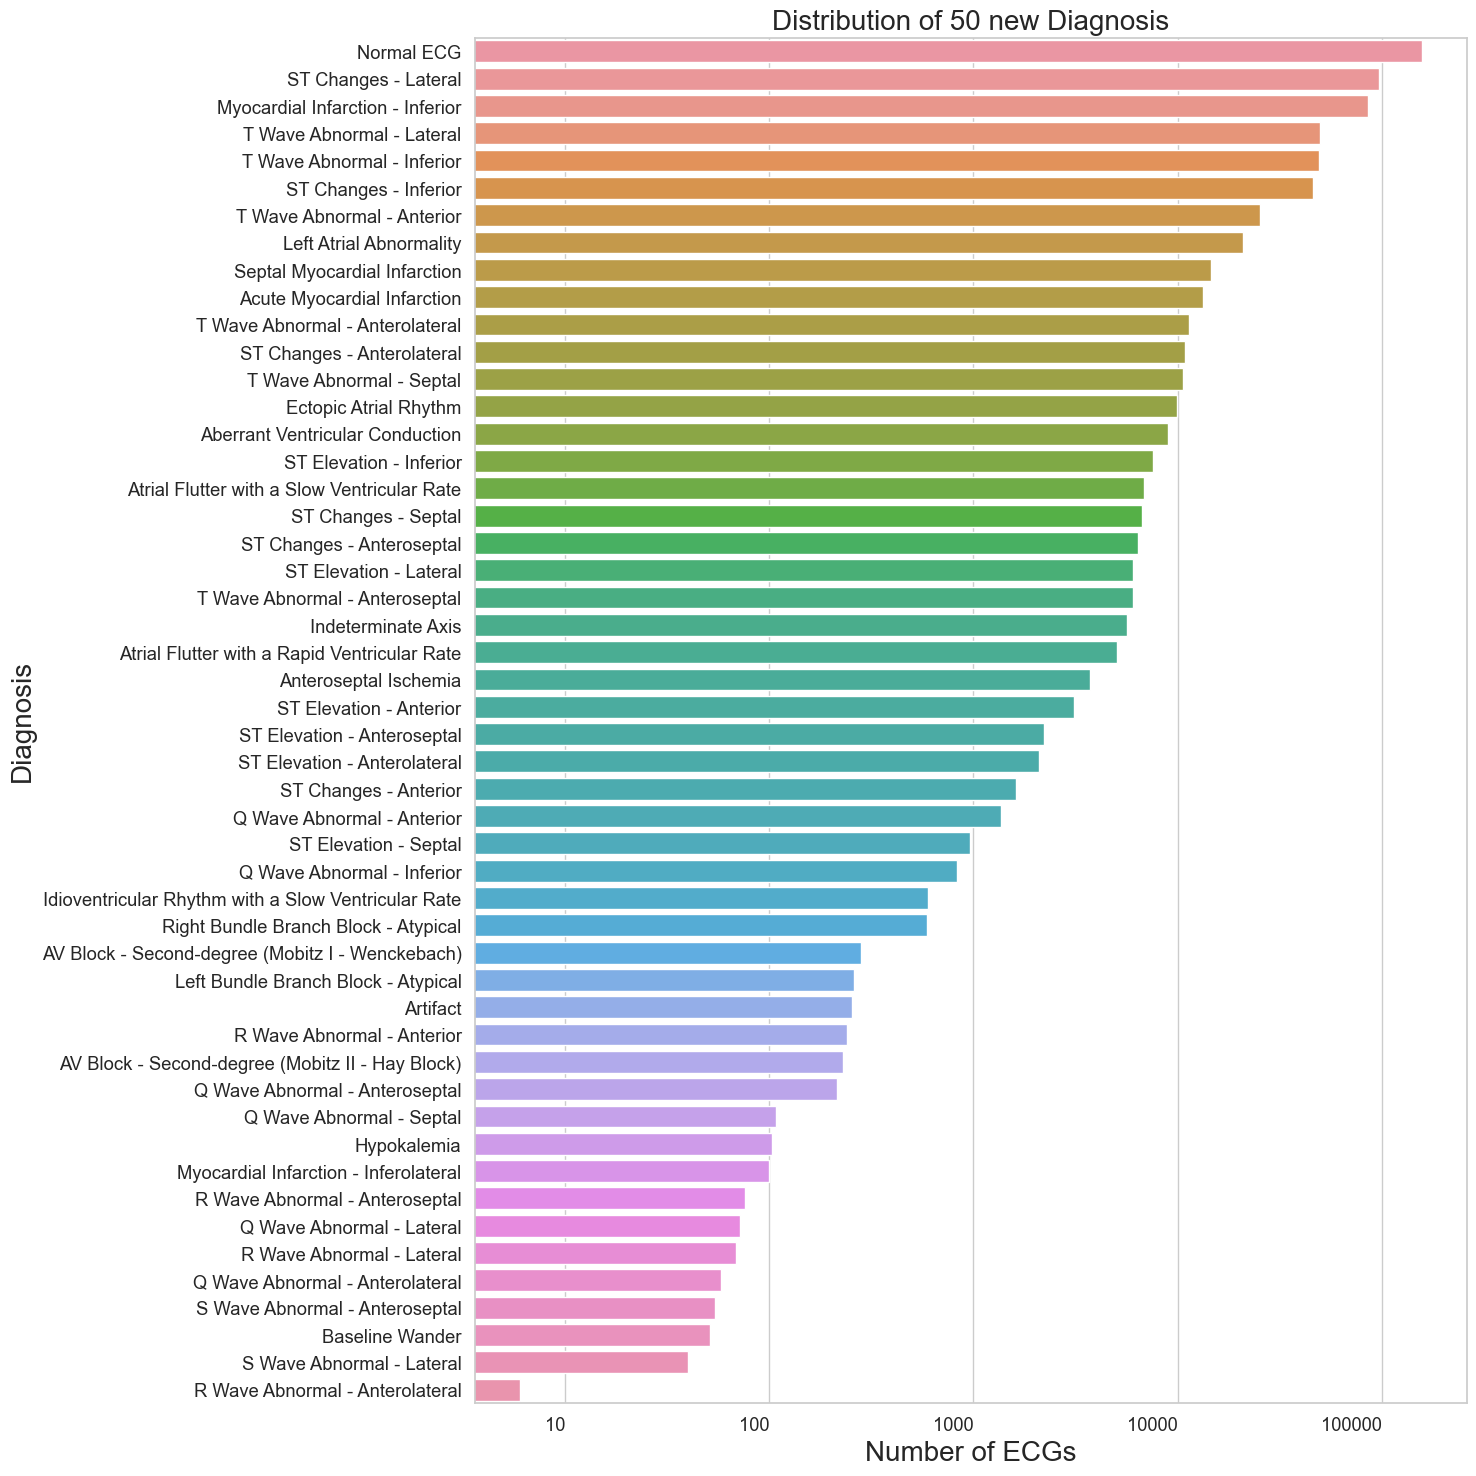

In [31]:
epsilon = 1e-7

# Define a function to format the x-axis labels as actual values
def format_func(value, tick_number):
    return str(int(value + epsilon))  # Format the labels as integers

#plot the new added categories and their count
diagnosis_diff = pd.read_csv('diagnosis_diff_final.csv')
diagnois_counts = pd.read_csv('diagnosis_counts.csv')
diagnois_counts = diagnois_counts.sort_values(by=['Count'], ascending=False)
#add to diagnosis_diff the count of each new diagnosis
diagnosis_diff = diagnosis_diff.merge(diagnois_counts, on="Diagnosis", how="left")
diagnosis_diff = diagnosis_diff.fillna(0)
diagnosis_diff = diagnosis_diff.rename(columns={"Count": "Number of ECGs"})
diagnosis_diff = diagnosis_diff.sort_values(by=['Number of ECGs'], ascending=False)
diagnosis_diff = diagnosis_diff[diagnosis_diff['Number of ECGs'] > 0]
print(diagnosis_diff.shape)

plt.figure(figsize=(15,15))
sns.set(style="whitegrid", font_scale=1.2) 
plt.xscale('log')
plt.title('Distribution of 50 new Diagnosis', fontsize=20)
ax = sns.barplot(x="Number of ECGs", y="Diagnosis", data=diagnosis_diff)
ax.set_xlabel("Number of ECGs",fontsize=20)
ax.set_ylabel("Diagnosis",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.tight_layout()
plt.show()



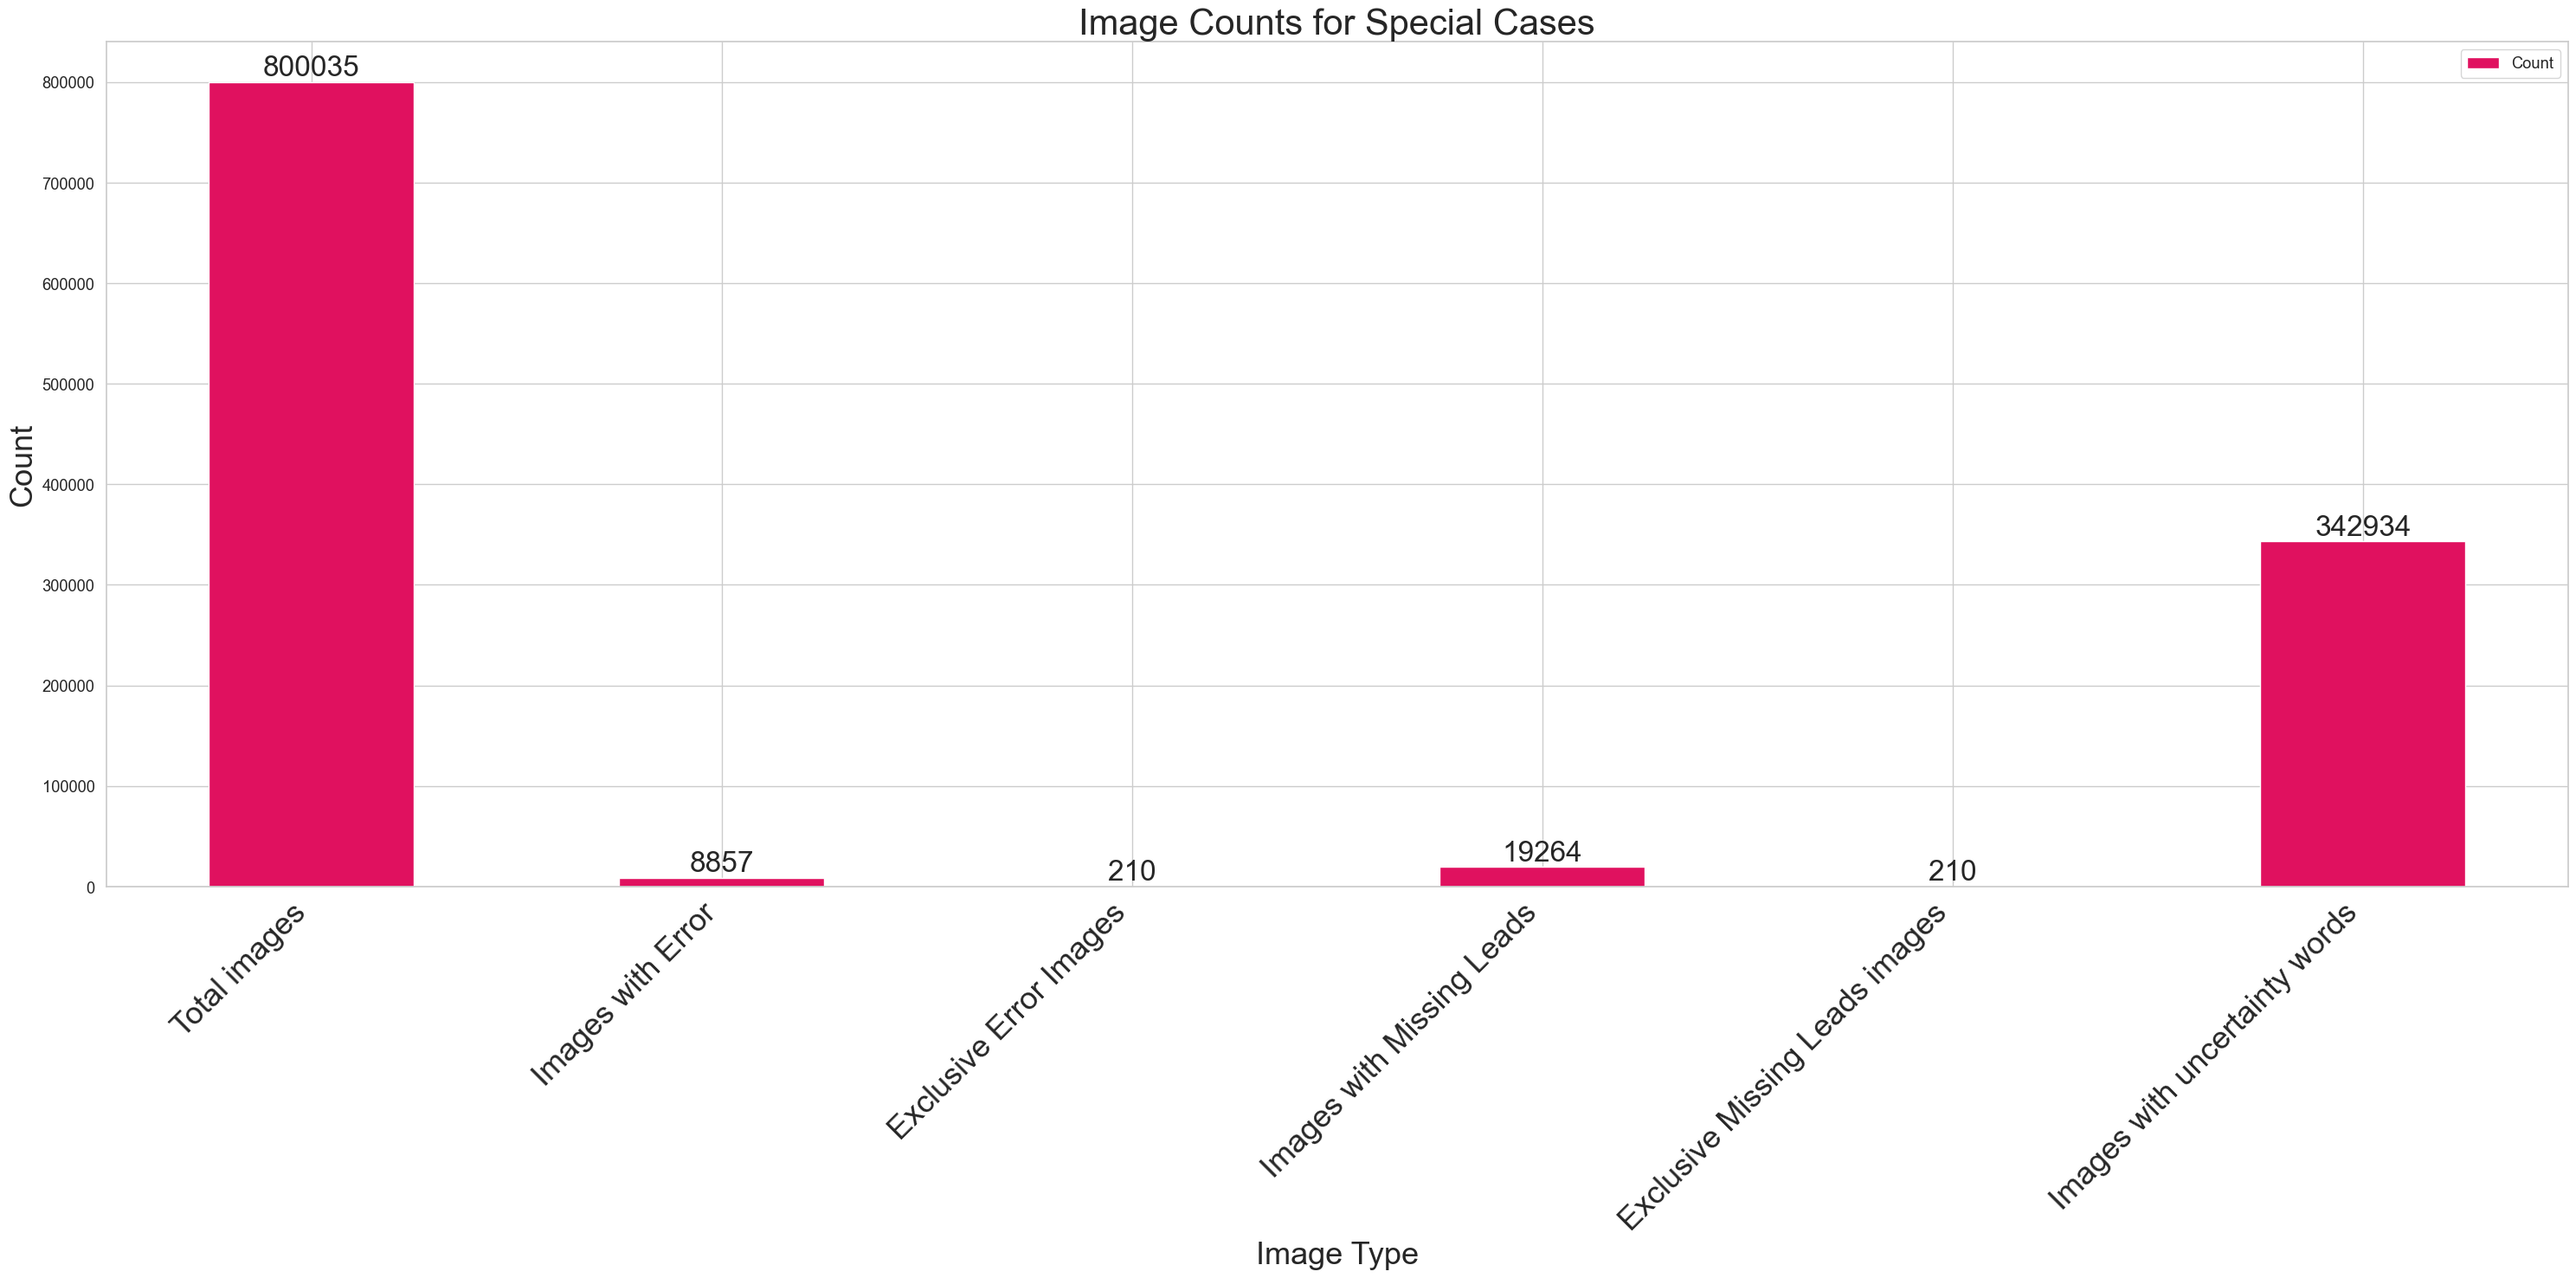

In [32]:
ax = images_special_cases.plot(kind='bar', color='#E0115F')
plt.xlabel('Image Type', fontsize=26)
plt.ylabel('Count', fontsize=26)
plt.title('Image Counts for Special Cases', fontsize=30)
ax.set_xticklabels(images_special_cases.Key, rotation=45, ha='right',fontsize=26)
for index, value in enumerate(images_special_cases.Count):
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=24)
plt.tight_layout()
plt.show()

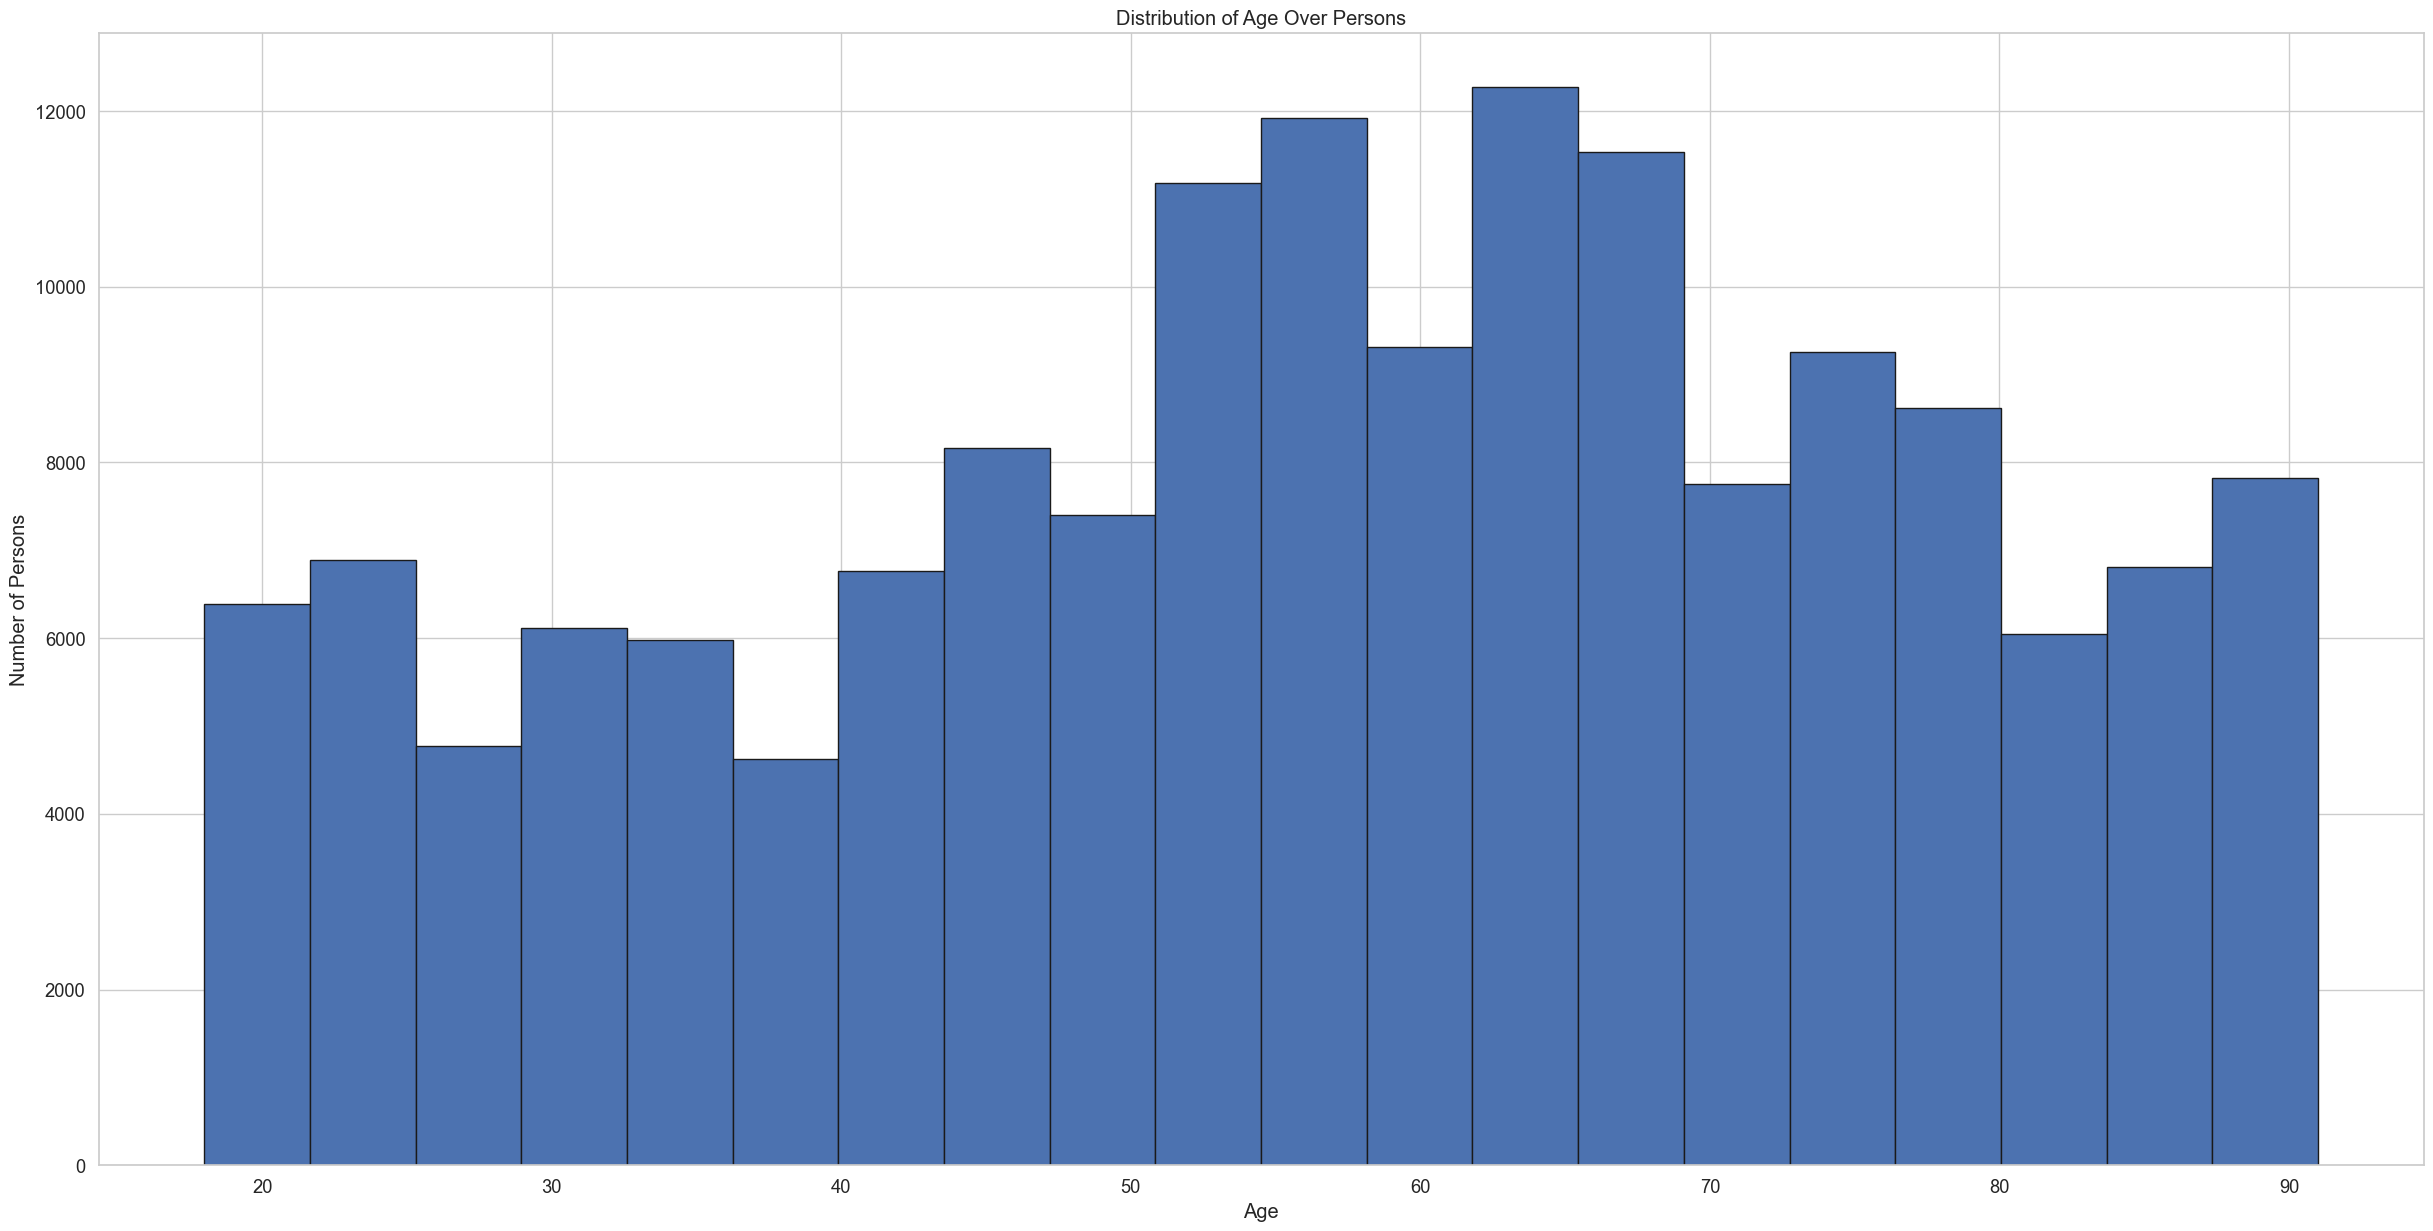

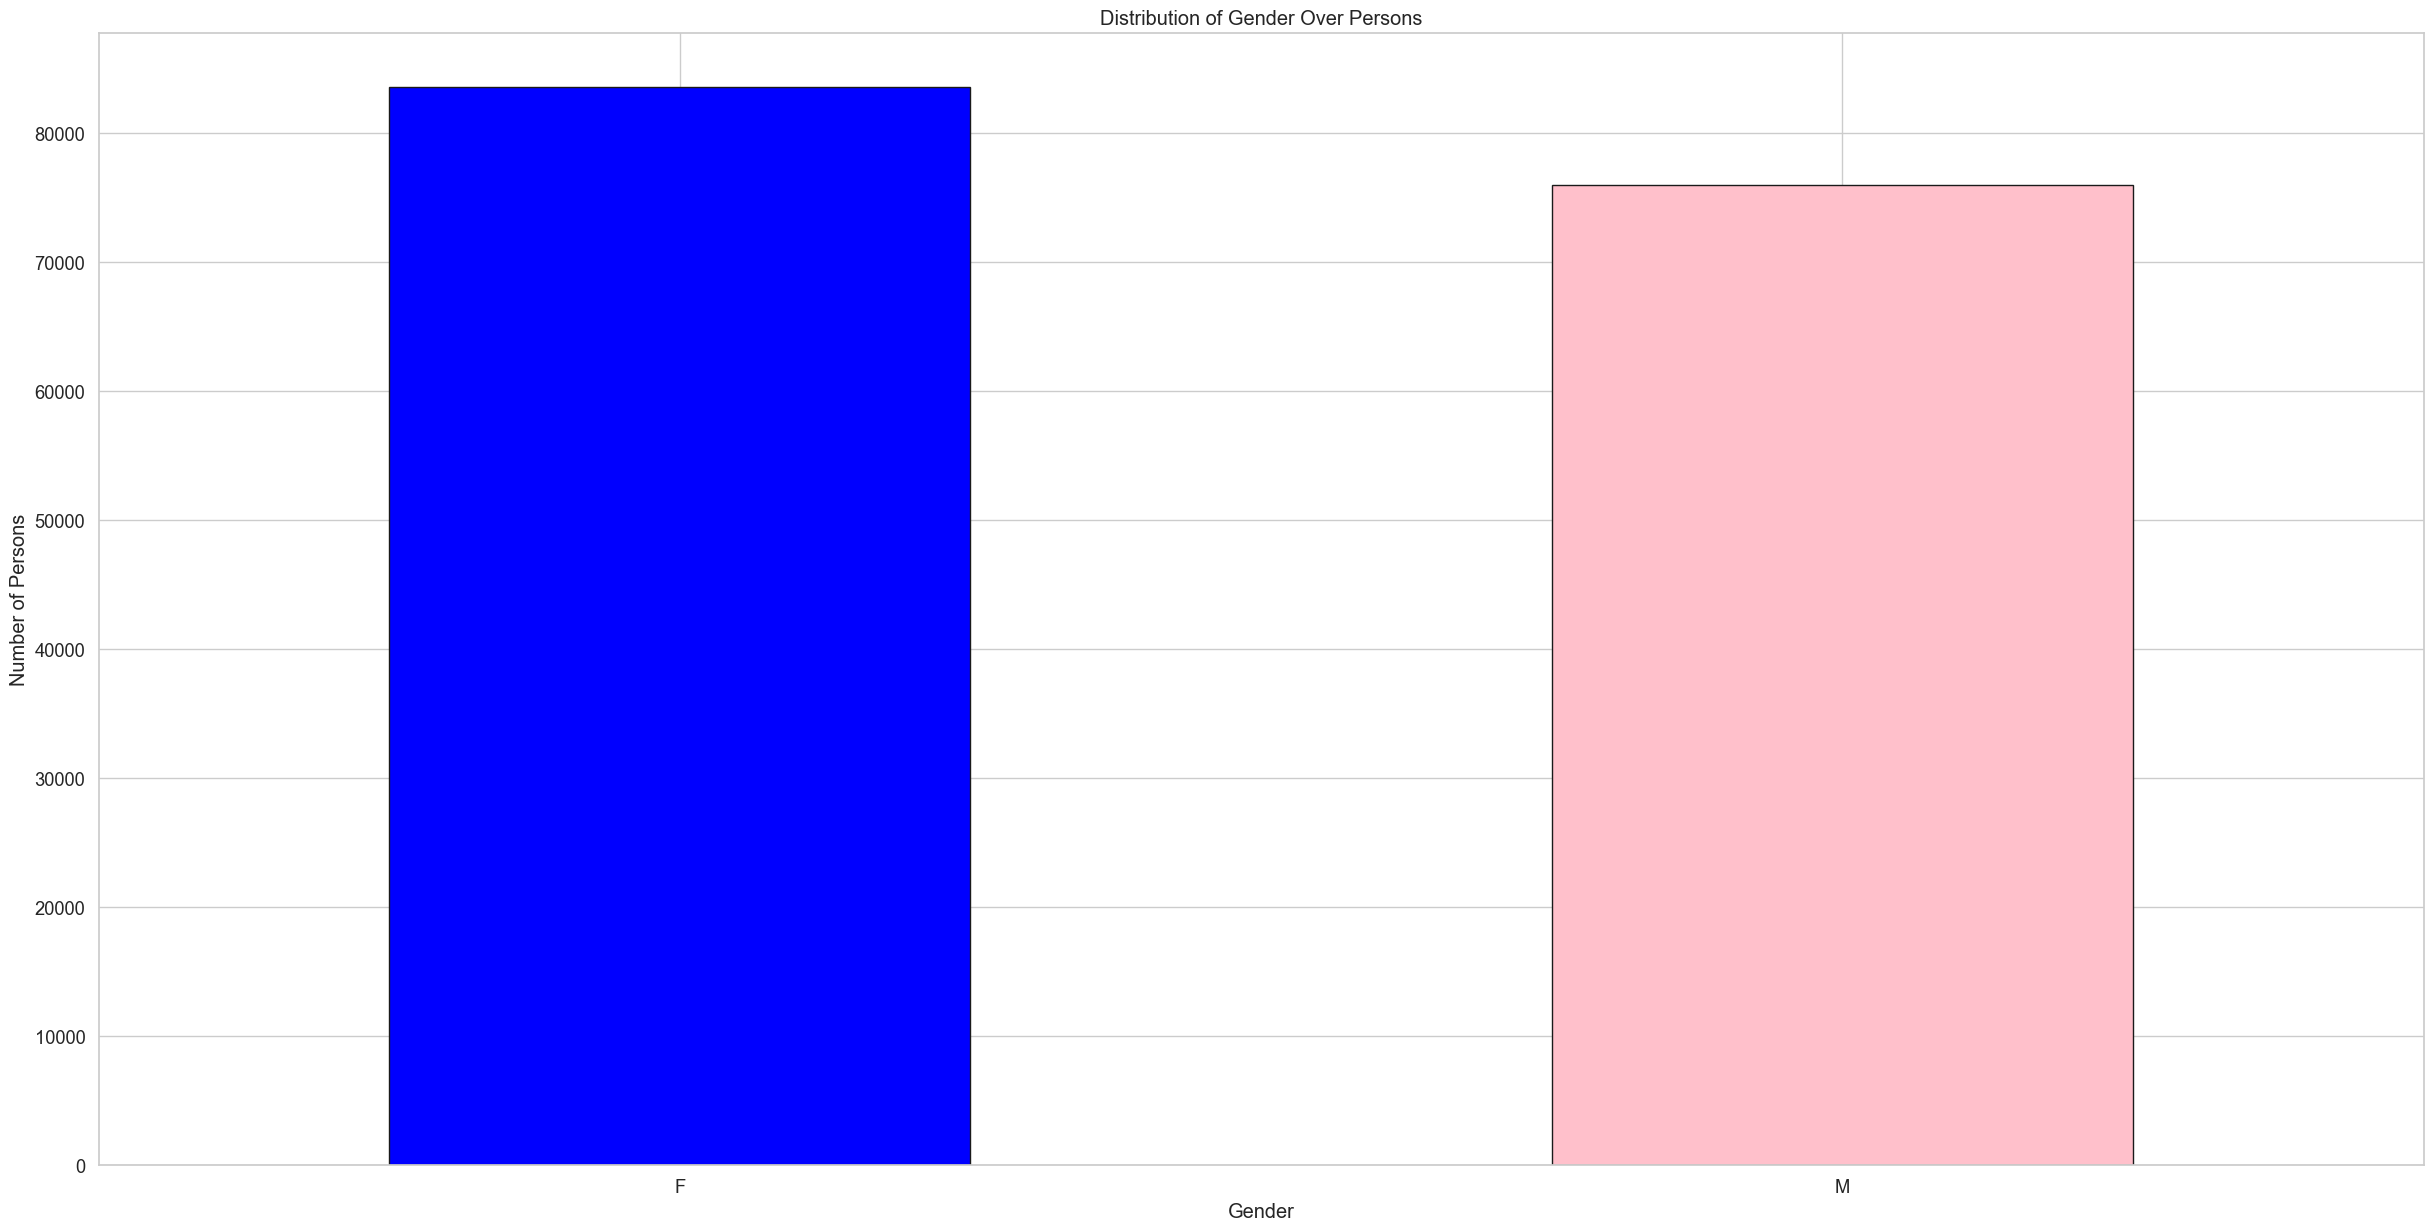

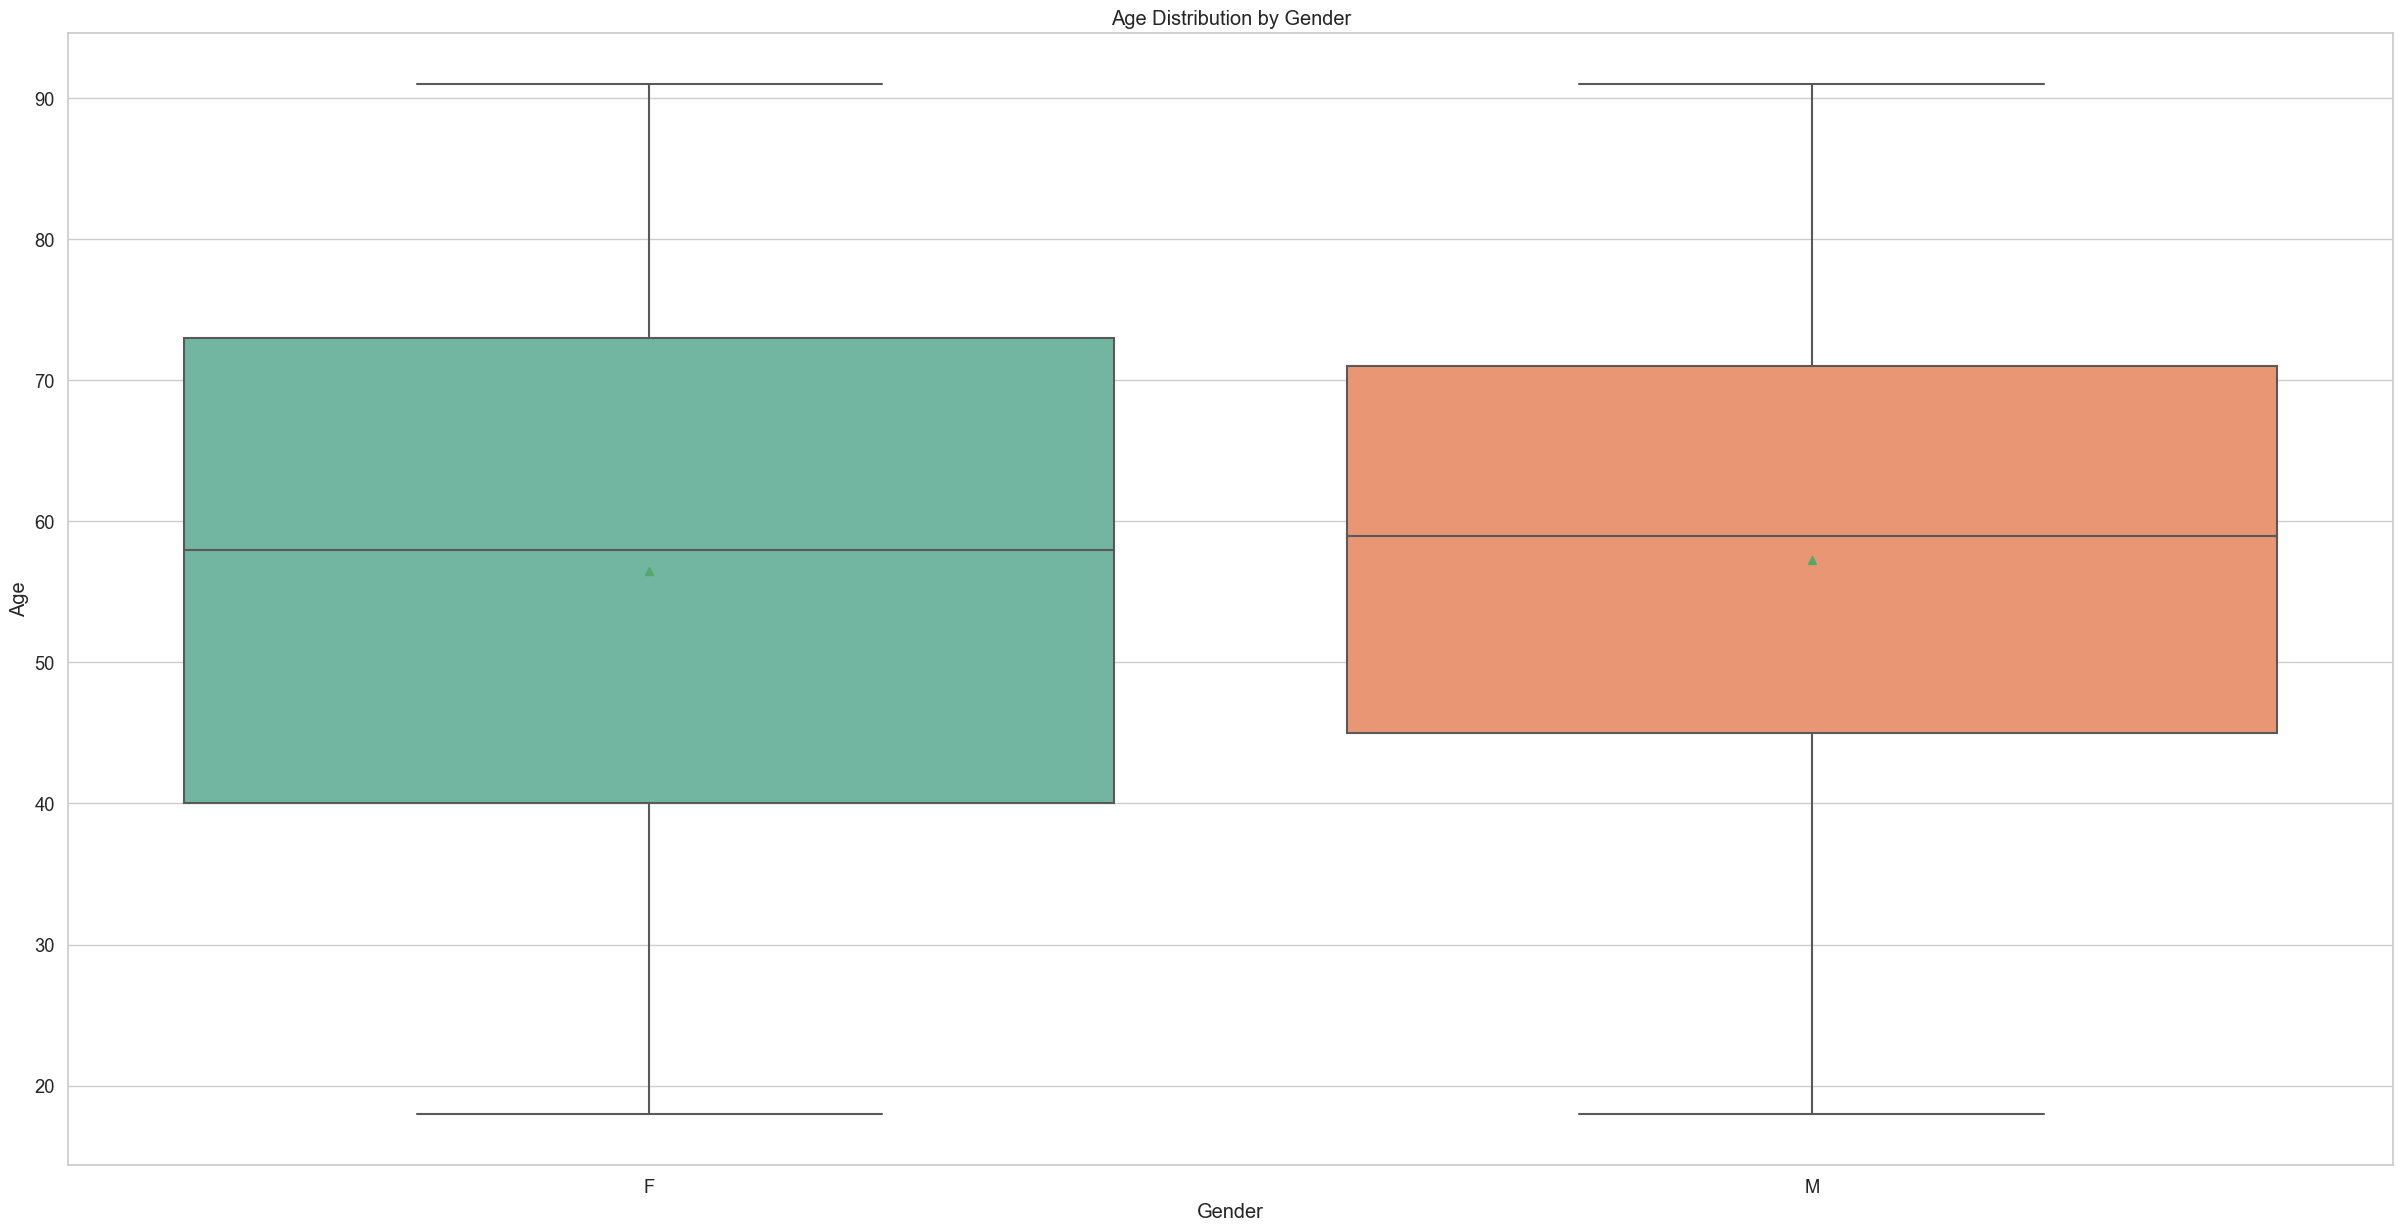

In [33]:
# Group by subject_id to calculate the distribution of age
ecg_with_patients_data_df = pd.read_csv('ecg_with_patients_data_df.csv')
age_distribution = ecg_with_patients_data_df.groupby('subject_id')['age'].first()
gender_distribution = ecg_with_patients_data_df.groupby('subject_id')['gender'].first()
#TODO: make df with subject_id and age and gender
age_gender_df = pd.DataFrame({
    'subject_id': age_distribution.index,
    'age': age_distribution.values,
    'gender': gender_distribution.values
})


# Plot the age distribution
age_distribution.plot(kind='hist', bins=20, edgecolor='k')
plt.title('Distribution of Age Over Persons')
plt.xlabel('Age')
plt.ylabel('Number of Persons')
plt.show()
# Plot the gender distribution
gender_counts = gender_distribution.value_counts()
gender_counts.plot(kind='bar', color=['blue', 'pink'], edgecolor='k')
plt.title('Distribution of Gender Over Persons')
plt.xlabel('Gender')
plt.ylabel('Number of Persons')
plt.xticks(rotation=0)
plt.show()

sns.boxplot(x='gender', y='age', data=age_gender_df, palette="Set2", showfliers=True, showmeans=True)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()
#TODO: change f to female and m to male
#TODO:  ages to be more accurate


C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\2710292609.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")


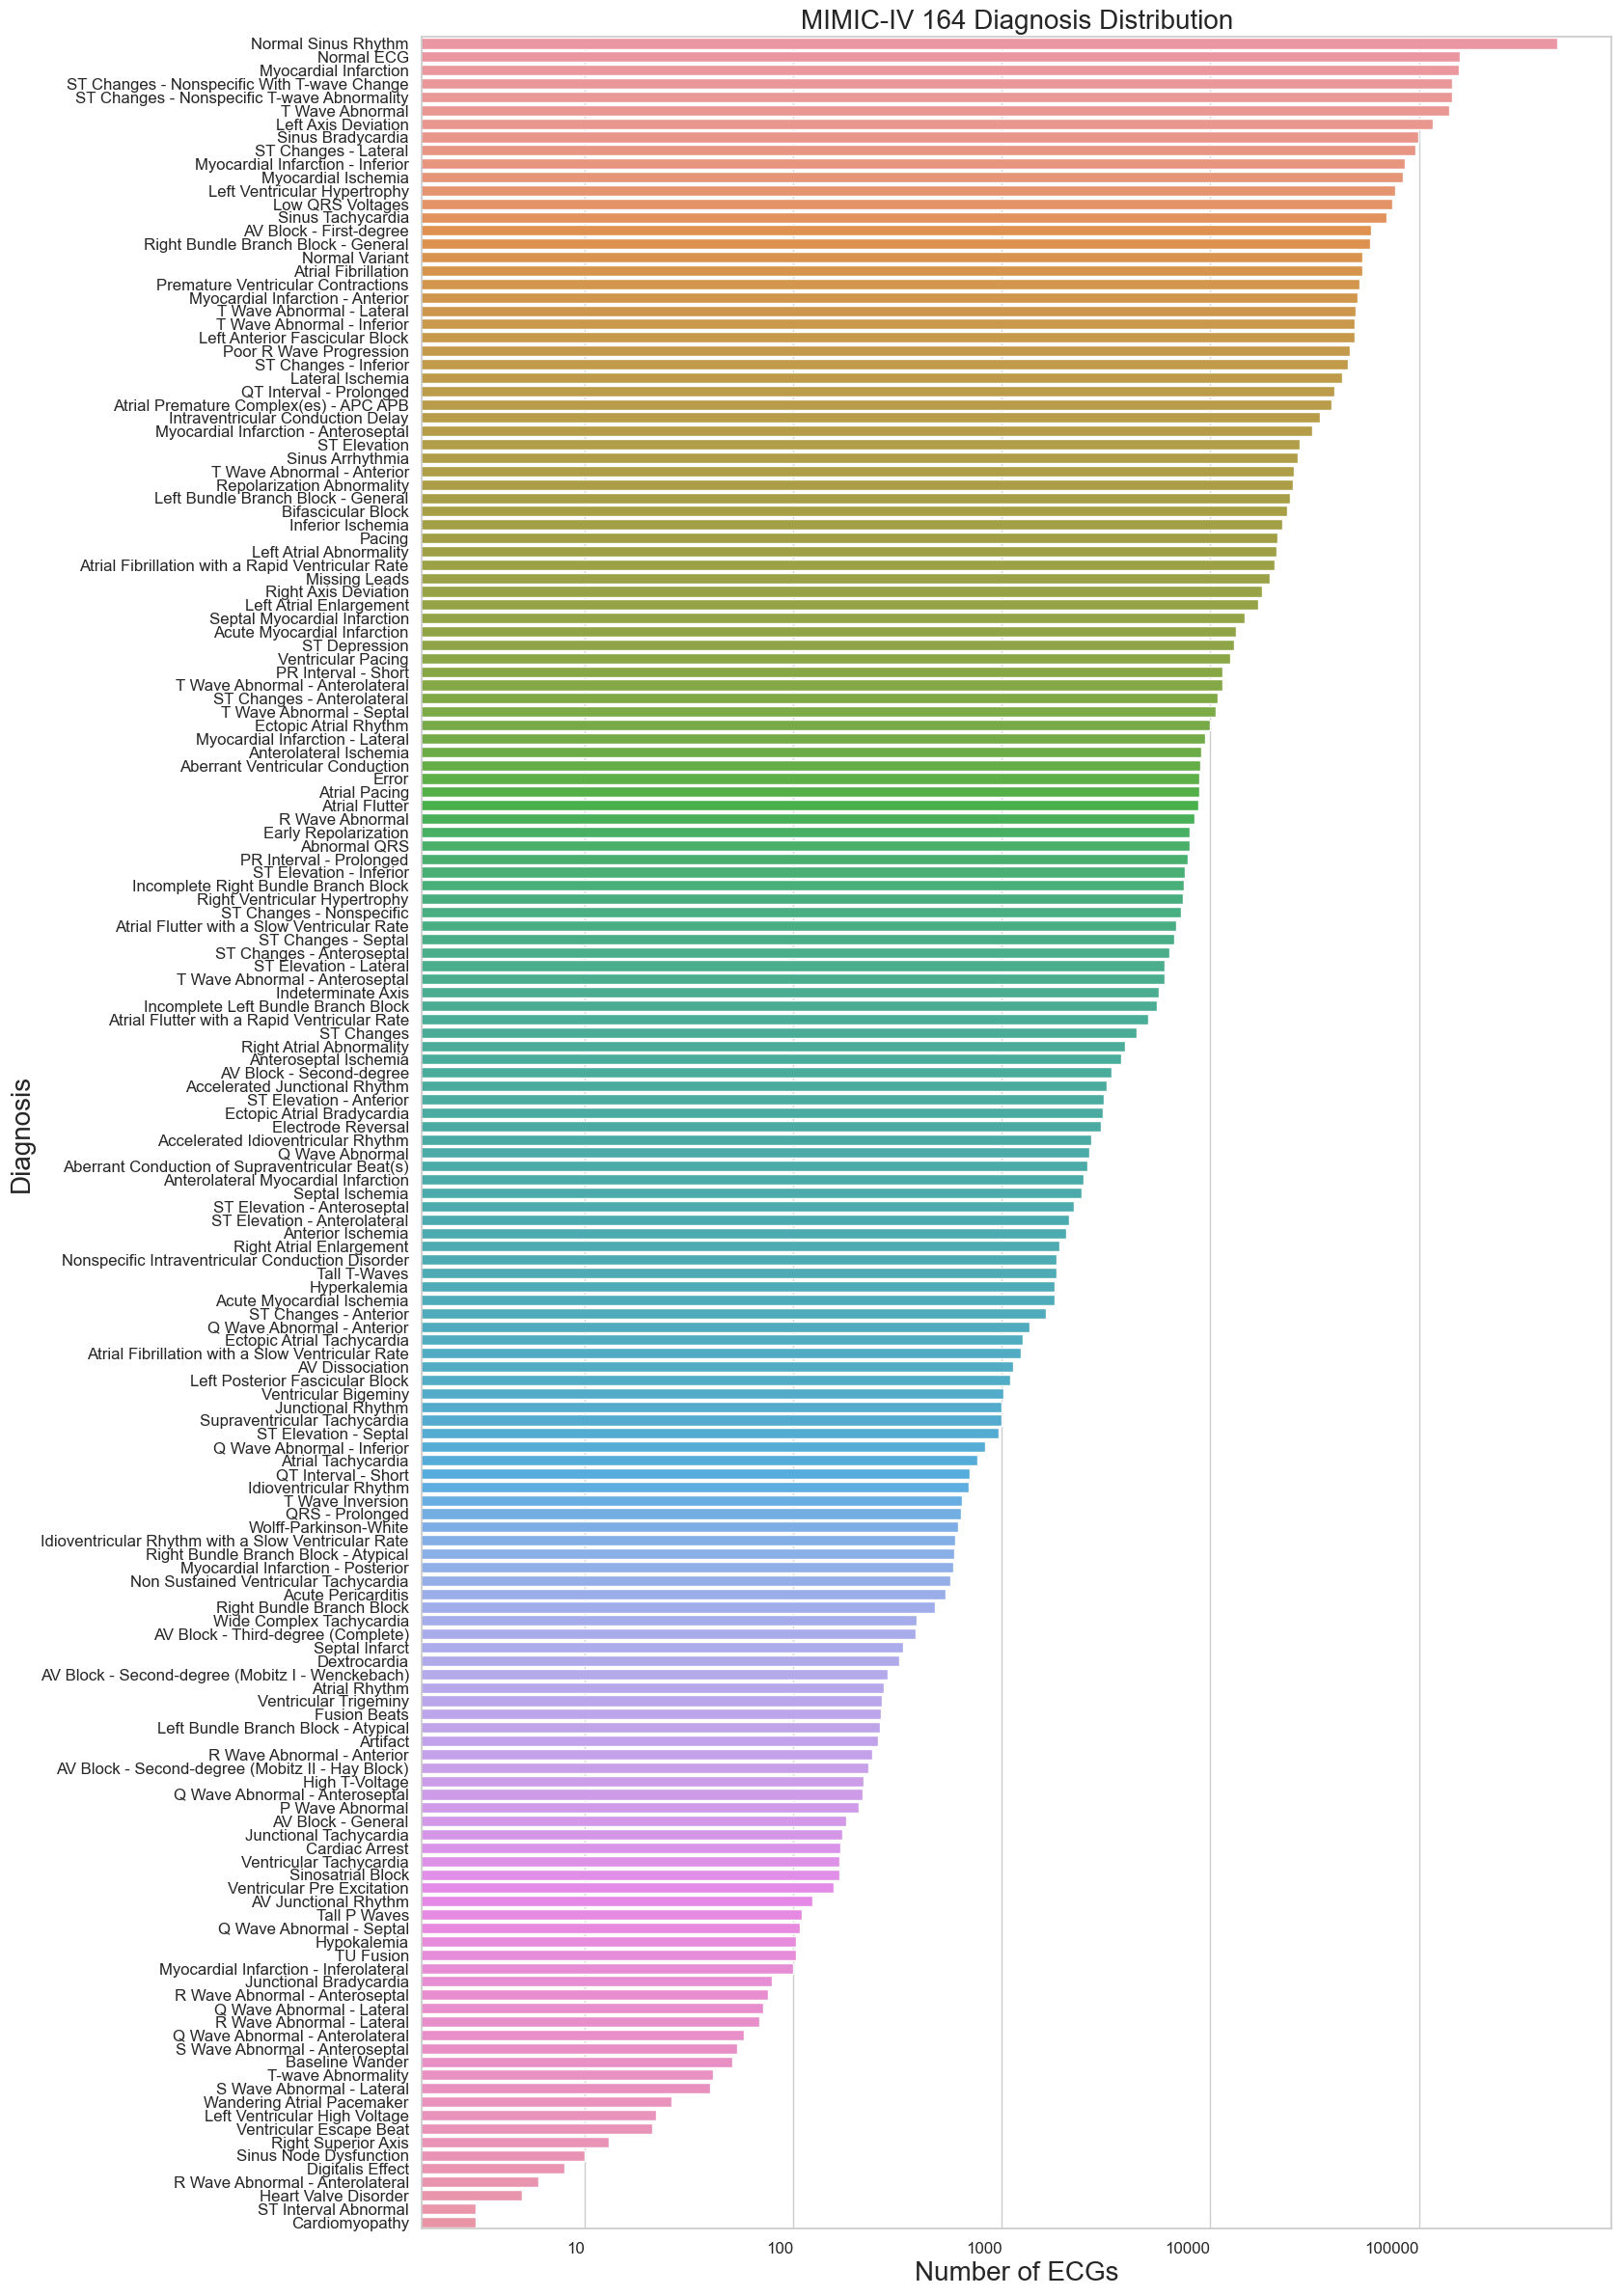

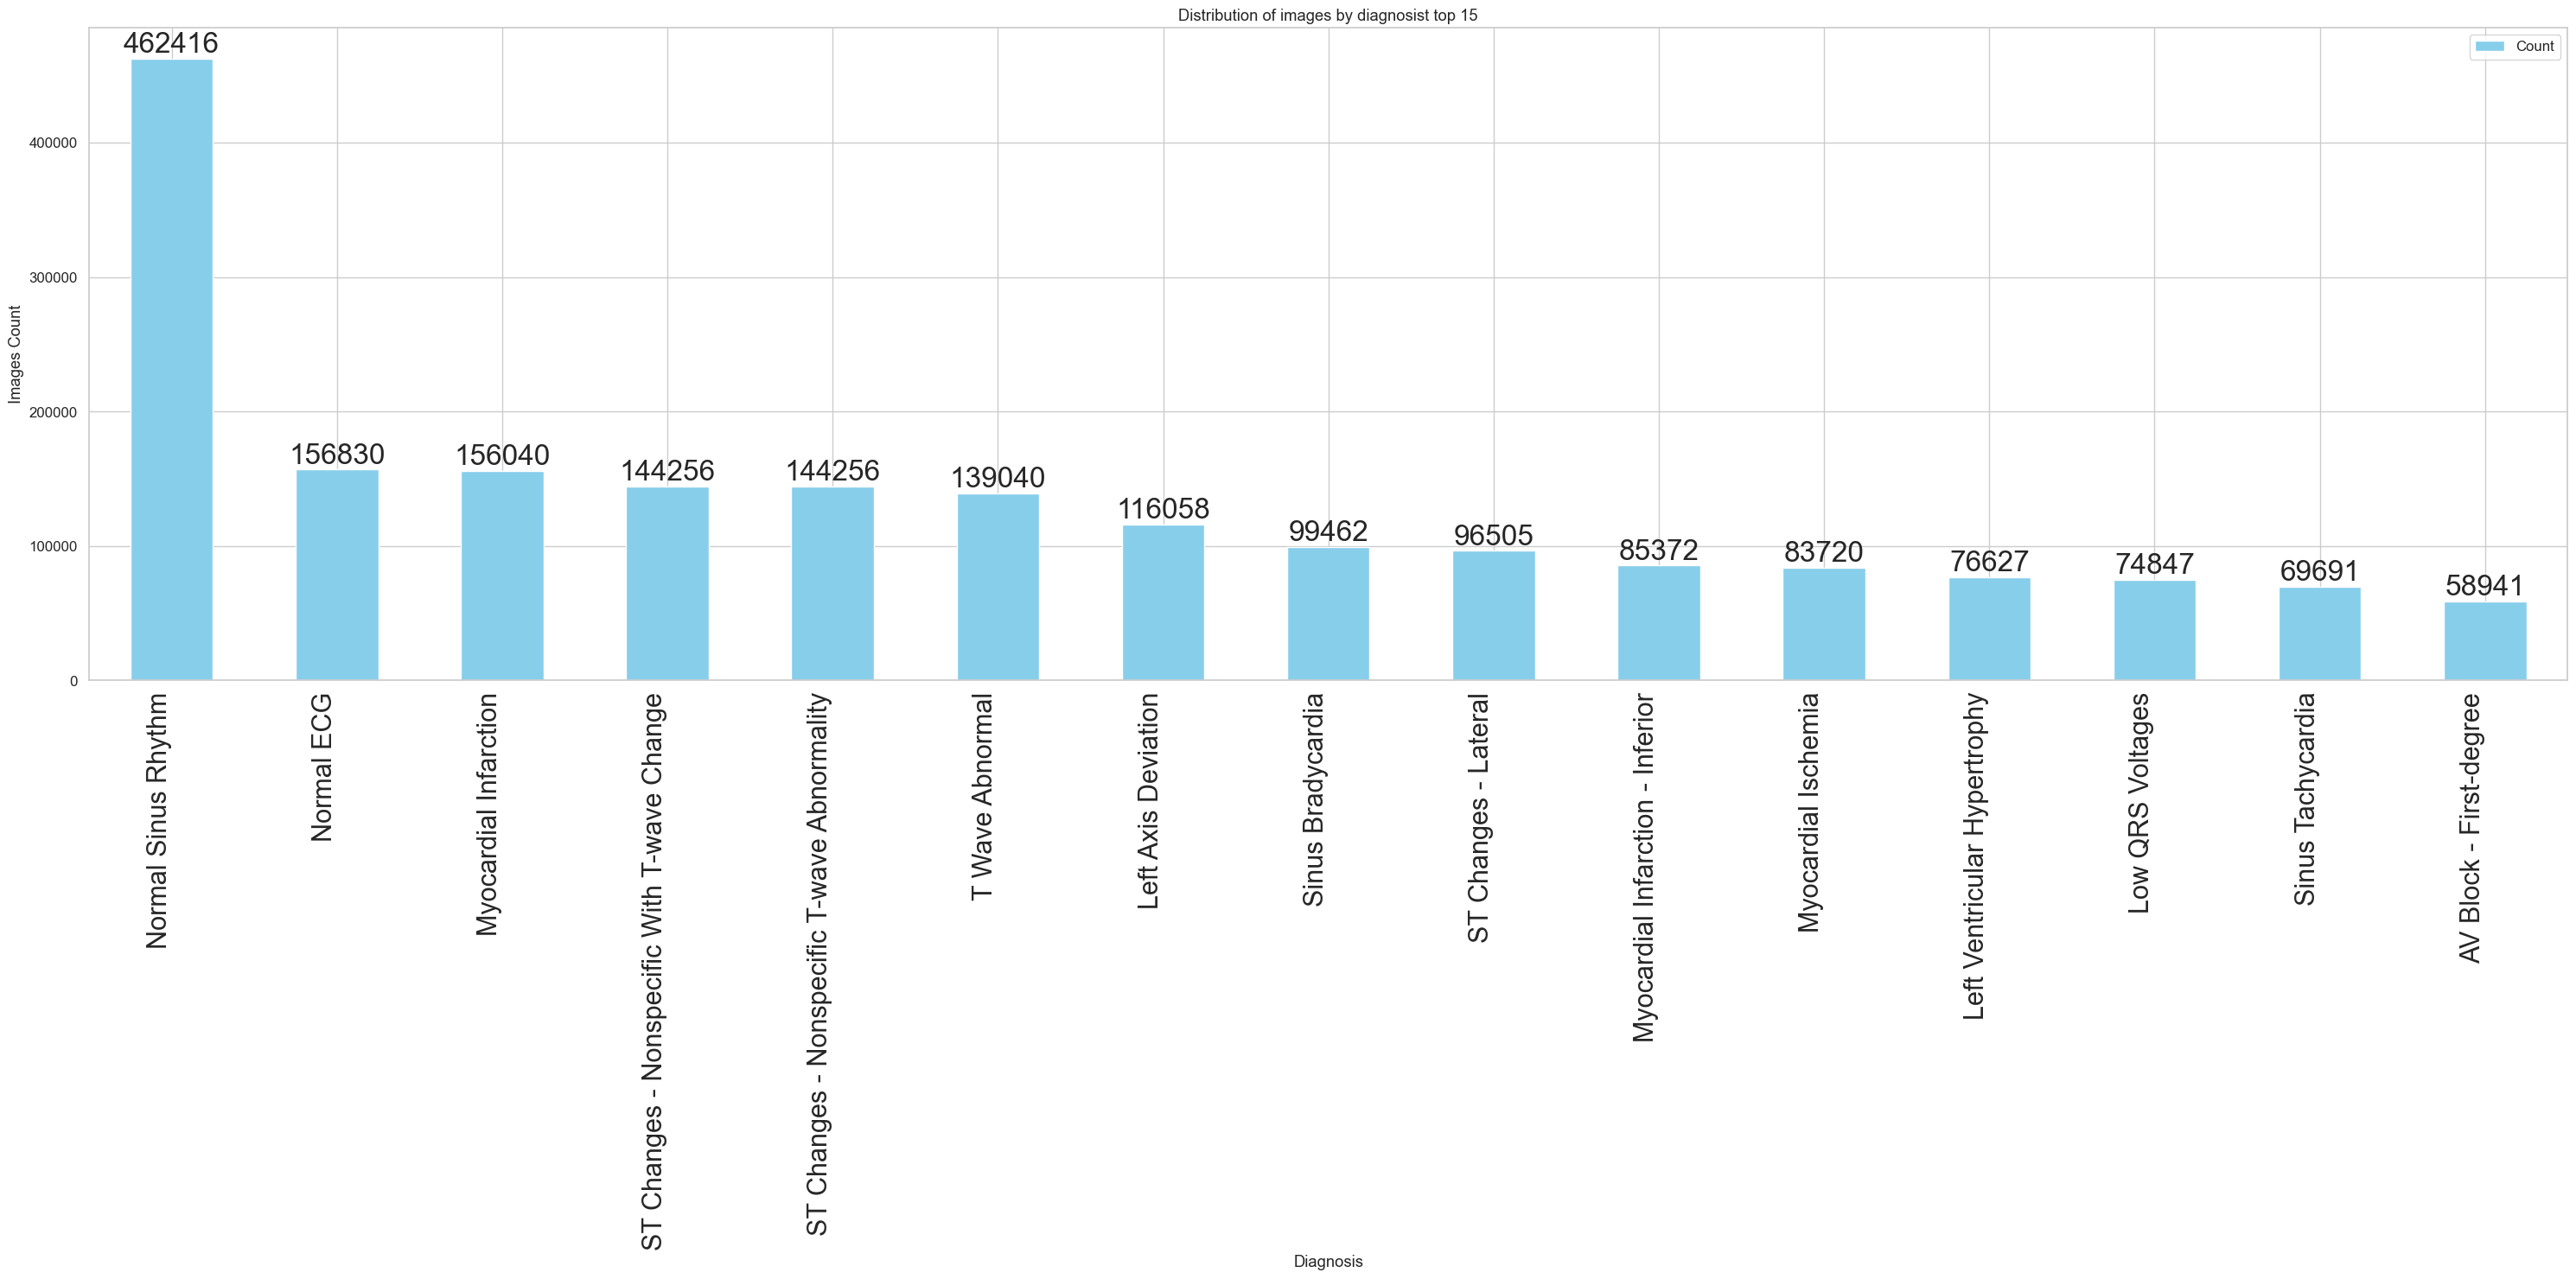

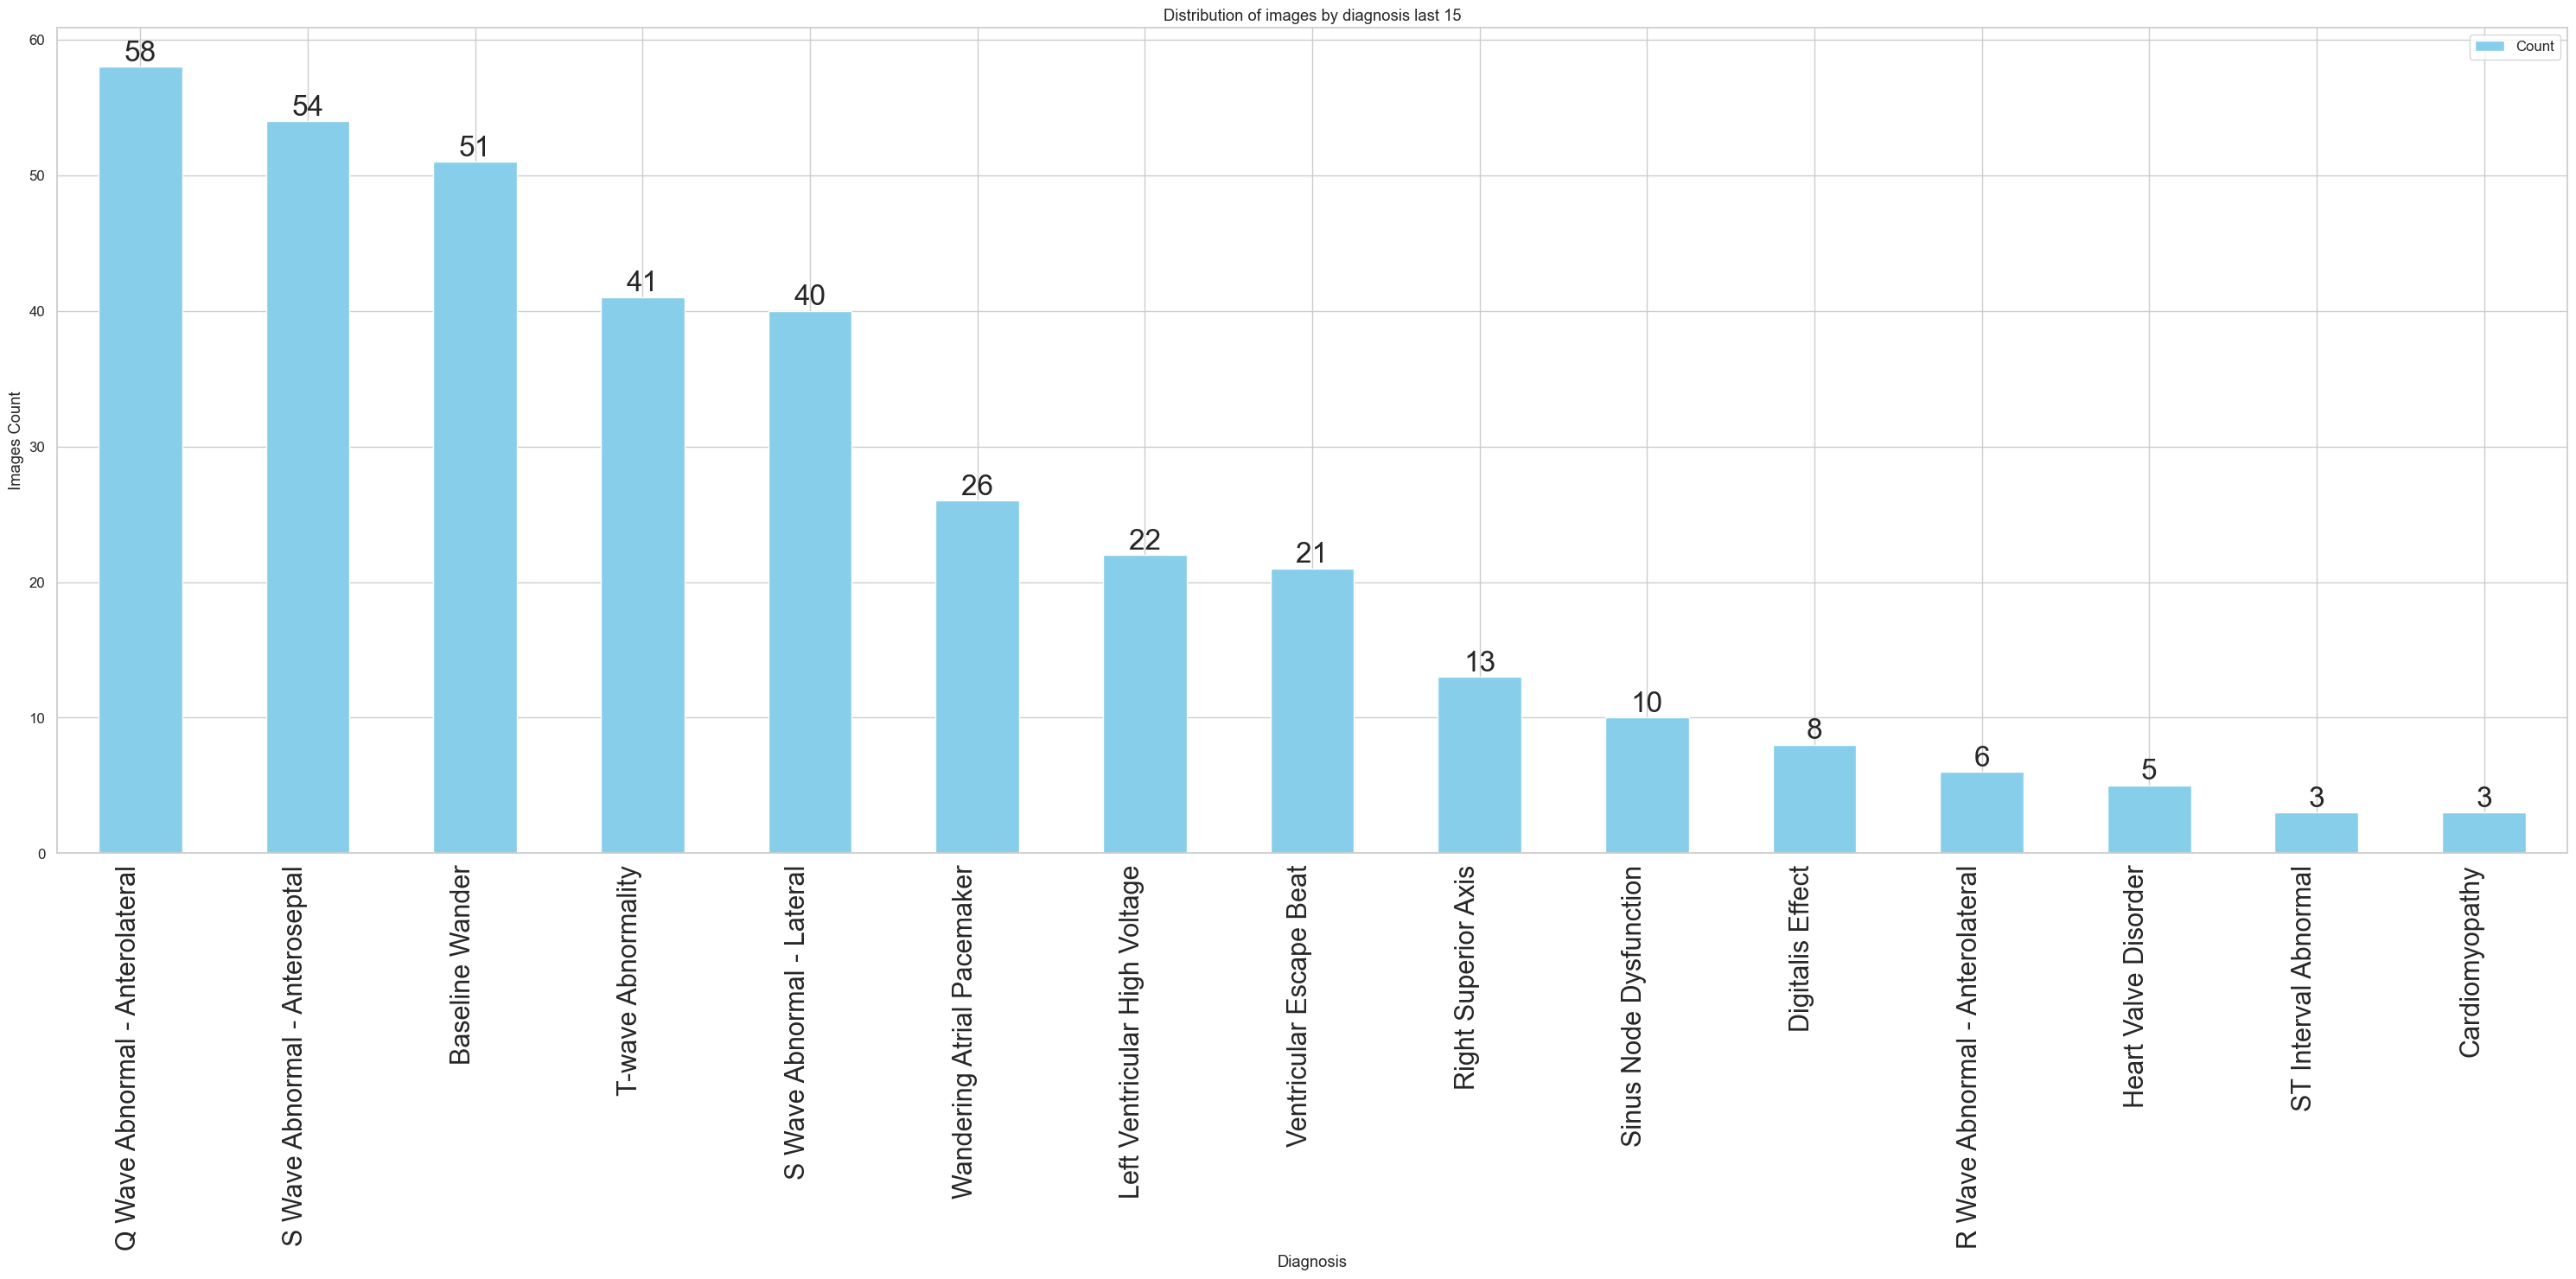

(164, 2)


In [38]:
diagnosis_counts = pd.read_csv('diagnosis_counts.csv')
diagnosis_counts = diagnosis_counts.sort_values(by='Count', ascending=False)


plt.figure(figsize=(17,24))
sns.set(style="whitegrid", font_scale=1.1) 
plt.xscale('log')
#TODO: change to mimic_iv title 
plt.title('MIMIC-IV 164 Diagnosis Distribution', fontsize=20)
ax = sns.barplot(x="Count", y="Diagnosis", data=diagnosis_counts)
ax.set_xlabel("Number of ECGs",fontsize=20)
ax.set_ylabel("Diagnosis",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.tight_layout()
plt.show()

#plot just the top 10 diagnosis
diagnosis_counts_head = diagnosis_counts.head(15)
ax = diagnosis_counts_head.plot(kind='bar', color='skyblue')
plt.title('Distribution of images by diagnosist top 15')
plt.xlabel('Diagnosis')
plt.ylabel('Images Count')
ax.set_xticklabels(diagnosis_counts_head.Diagnosis, rotation=90, ha='right',fontsize=22)
for index, value in enumerate(diagnosis_counts_head.Count):
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=24)
plt.tight_layout()
plt.show()

diagnosis_counts_tail = diagnosis_counts.tail(15)
ax = diagnosis_counts_tail.plot(kind='bar', color='skyblue')
plt.title('Distribution of images by diagnosis last 15')
plt.xlabel('Diagnosis')
plt.ylabel('Images Count')
ax.set_xticklabels(diagnosis_counts_tail.Diagnosis, rotation=90, ha='right',fontsize=22)
for index, value in enumerate(diagnosis_counts_tail.Count):
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=24)
plt.tight_layout()
plt.show()

print(diagnosis_counts.shape)




C:\Users\itayt\AppData\Local\Temp\ipykernel_12260\2341301726.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")


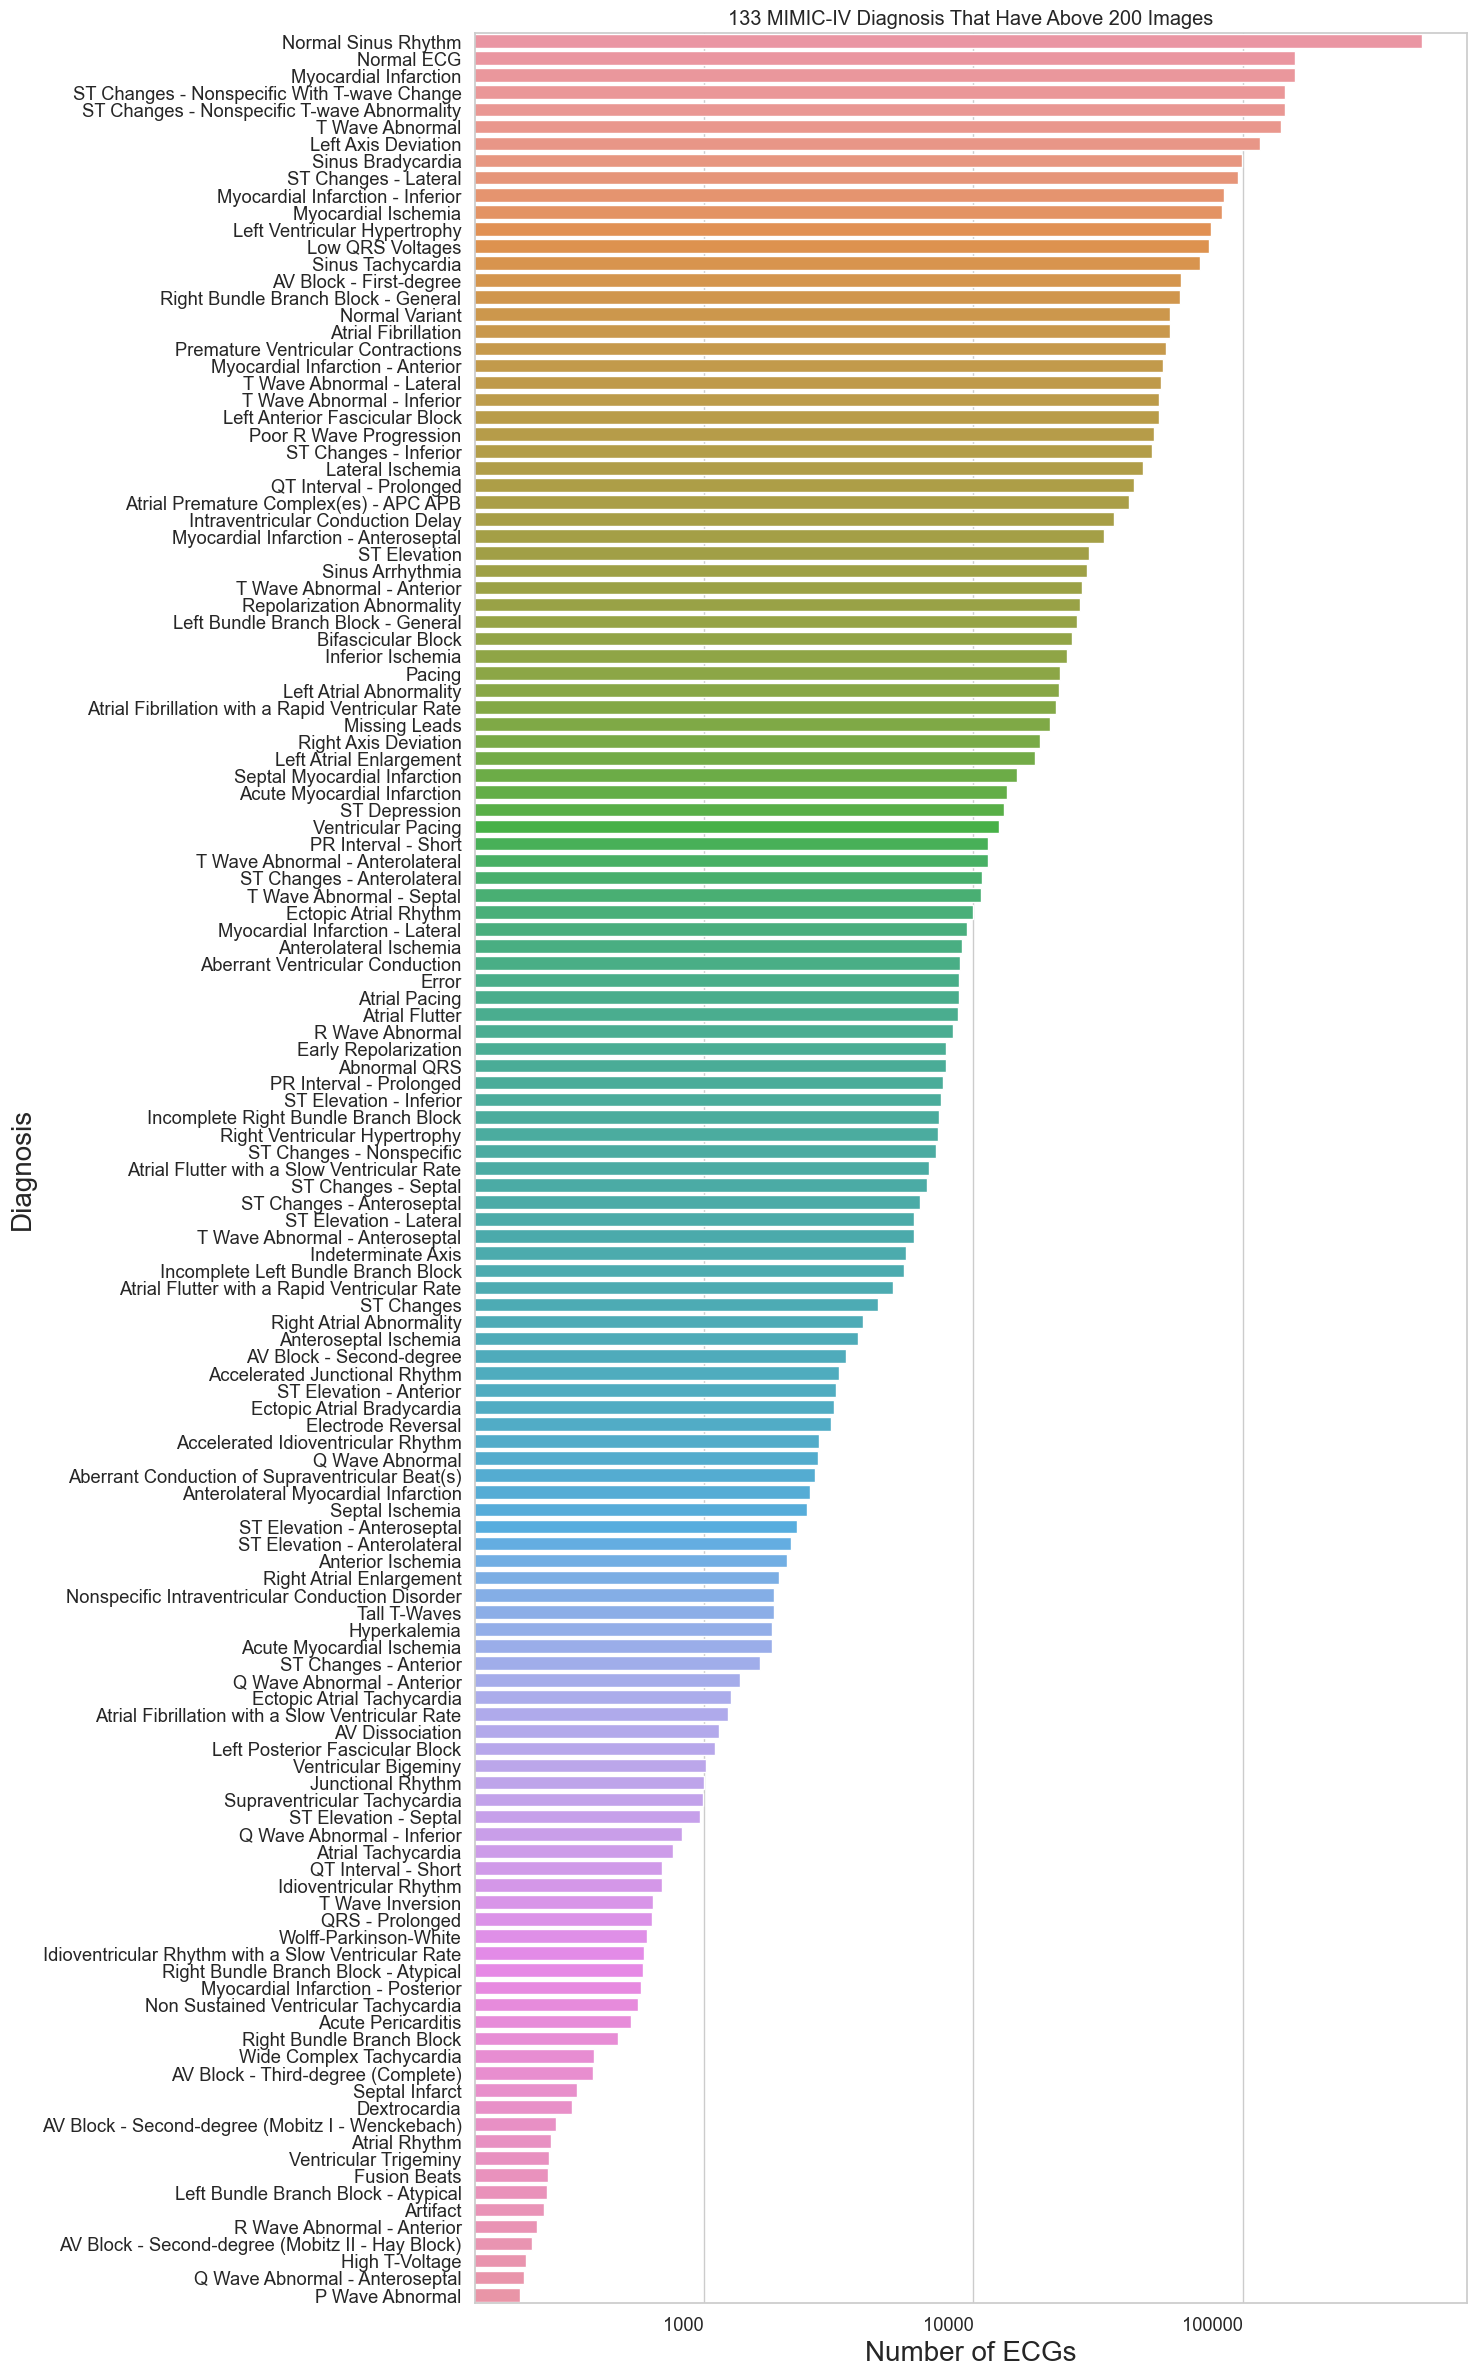

133


In [39]:
diagnosis_counts = diagnosis_counts.sort_values(by='Count', ascending=False)

diagnosis_counts = diagnosis_counts[diagnosis_counts['Count'] > 200]


plt.figure(figsize=(15,24))
sns.set(style="whitegrid", font_scale=1.2) 
plt.xscale('log')
#TODO: change to mimic_iv title 
plt.title('133 MIMIC-IV Diagnosis That Have Above 200 Images')
ax = sns.barplot(x="Count", y="Diagnosis", data=diagnosis_counts)
ax.set_xlabel("Number of ECGs",fontsize=20)
ax.set_ylabel("Diagnosis",fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.tight_layout()
plt.show()

diagnosis_above_200 = diagnosis_counts[diagnosis_counts['Count'] > 200]
diagnosis_above_200 = len(diagnosis_above_200)
print(diagnosis_above_200)


## ***Part III: Filtering the ECG images Before rendering***

We have filtered 10,102 ECG images that were not suitable for rendering.  
The main reasons for filtering were variance and the number of leads with high variance - images that were too noisy.  
The function 'is_signal_good' is used to filter the images.  

def is_signal_good(signal):  

        count_num_bad_leads = 0
        for lead in range(len(signal)):  
            describe = mstats.describe(signal[lead])  
            if describe.variance >= 0.5:  
                count_num_bad_leads += 1  
            if describe.variance >=2:  
                return False  
        if count_num_bad_leads >= 2:  
            return False  
  
summarize the filtering:  
* 1.1: checking if one lead have a very unusual lead with huge variance above 2 we are filtering the image  
* 1.2: checking if at least two leads have variance above 0.5 we are filtering the image  

## ***Part IV: Loading the data and run some unitests***
###  Step 1: Reading the data and creating a dataloader

In [54]:
LOADING_ALL_DATA = False
def load_and_process_data(idx):
    ecg_dataset[idx]

if LOADING_ALL_DATA:
    # Path to the "files" directory
    files_directory = Path("./files")
    ecg_dataset = ECGDataset(files_directory)

    # Create the DataLoader
    batch_size = 64
    num_workers = multiprocessing.cpu_count()
    data_loader = DataLoader(ecg_dataset, batch_size=batch_size, shuffle=False, collate_fn=ecg_dataset.collate_fn,num_workers=num_workers)

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(load_and_process_data, range(len(ecg_dataset)))

    num_batches = len(data_loader)
    total_samples = len(ecg_dataset)
    num_batches = len(data_loader)
    last_batch_size = total_samples % batch_size

    print("Total samples:", total_samples)
    print("Number of batches:", num_batches)
    print("Last batch size:", last_batch_size)

In [ ]:
CHECK_SIZE = False

def get_data_loader_size(dataloader):
    total_size = 0
    for batch in dataloader:
        total_size += sys.getsizeof(batch)
    return total_size
if CHECK_SIZE:
    dataloader_size_bytes = get_data_loader_size(ecg_dataset)
    dataloader_size_gb = dataloader_size_bytes / (1024**3)  # Convert bytes to gigabytes
    print(f"DataLoader size: {dataloader_size_gb:.3f} GB")


### Step 2: Running some unit tests

In [ ]:
from tests import SignalDataTestCase
run_tests = False
def run_unit_tests():
    # Load the test case from the SignalDataTestCase class
    test_suite = unittest.TestLoader().loadTestsFromTestCase(SignalDataTestCase)

    # Create a test runner
    test_runner = unittest.TextTestRunner()
    start_time = time.time()
    test_result = test_runner.run(test_suite)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return test_result, elapsed_time

if run_tests:
    test_result, elapsed_time = run_unit_tests()

    # Check if any errors occurred during the test run
    if test_result.errors:
        print("\nErrors occurred during the test run:")
        for test, error in test_result.errors:
            print(f"Test: {test}")
            print(f"Error: {error}")
            print("-" * 30)

    # Check if any failures occurred during the test run
    if test_result.failures:
        print("\nFailures occurred during the test run:")
        for test, failure in test_result.failures:
            print(f"Test: {test}")
            print(f"Failure: {failure}")
            print("-" * 30)

    # Print the test results summary
    print(f"\nRan {test_result.testsRun} tests in {elapsed_time:.3f} seconds.")
    if test_result.wasSuccessful():
        print("All tests passed!")
    else:
        print("Some tests failed.")

## ***Part V: Rendering the data to images***

In [ ]:
ecg_formats = [0]
rsi.main(ecg_formats)